In [6]:
import pandas as pd
import shutil
import numpy as np

# import skbio
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
from statsmodels.formula.api import ols
# import researchpy as rp
from matplotlib import rcParams
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
#from statsmodels.stats.multicomp import MultiComparison
#dunns
from itertools import combinations

from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng
import warnings

# import plotly.express as px
# import plotly.graph_objects as go
import os
import re
# from plotly.subplots import make_subplots

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import statsmodels.api as sm

import statsmodels.api as sa
# import scikit_posthocs as sp

from pingouin import kruskal

#from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
import itertools

rcParams.update({'figure.autolayout': True})

/home/witham/opt/anaconda3/envs/qpcr/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [7]:
# date1 = '11.3.21'
# date2 = '18.3.21'
# finaldate = '11.3.21+18.3.21'

In [8]:
# if not os.path.exists(f'../../../../data/plots/luminescence/{finaldate}'):
#     os.mkdir(f'../../../../data/plots/luminescence/{finaldate}')

In [9]:
# if not os.path.exists(f'../../../../data/luminescence/to_be_sorted/{finaldate}'):
#     os.mkdir(f'../../../../data/luminescence/to_be_sorted/{finaldate}')

In [10]:
# #copy files to new folder
# src1 = f'../../../../data/luminescence/to_be_sorted/{date1}/output_raw.csv'
# dst1 = f'../../../../data/luminescence/to_be_sorted/{finaldate}/output_raw_{date1}.csv'
# src2 = f'../../../../data/luminescence/to_be_sorted/{date2}/output_raw.csv'
# dst2 = f'../../../../data/luminescence/to_be_sorted/{finaldate}/output_raw_{date2}.csv'
# shutil.copyfile(src1,dst1)
# shutil.copyfile(src2,dst2)

In [11]:
def add_promoter_column(df,promoter_number,promoter):
    df.loc[df.name.str.match(fr'(^{promoter_number}.*)')==True, 'Promoter'] = promoter
    

In [12]:
#add TF coexpression column
def add_tf_column(df, TF_number, TF):
    """function to add TF added column based on an input df, a TF_number and a TF name"""
    df.loc[df.name.str.contains(fr'\+{TF_number}\+')&df.TF_added.isnull()==True, 'TF_added'] = TF
    for index, value in df.loc[df.name.str.contains(fr'\+{TF_number}\+')&df.TF_added.notnull()].TF_added.items():
        if re.match(fr'.*{TF}.*', value):
            pass
        else:
            df.iloc[index, df.columns.get_loc('TF_added')] = f'{value}+{TF}'


In [13]:
def add_wellcalibrator_column(df,calibrator_code,calibrator):
    #if ends with calibrator_code, change well calibrator column value to the well calibrator name
    df.loc[df.name.str.contains(fr'.*{calibrator_code}$')==True, 'Well_calibrator'] = calibrator

In [14]:
# #divide by NOS calibrator (mean nos-LucN/35SLucF luminescence)
# def batch_correction(df,calibrator_promoter_name):
#    #print(df[df.Promoter==calibrator_promoter_name])
#     calibrator = df[df.Promoter==calibrator_promoter_name]
#     calibrator_mean = calibrator['nluc/fluc'].mean(axis=0)
#     df['corrected_luminescence'] = df['nluc/fluc']/calibrator_mean*100 

In [15]:
def batch_correction(df,calibrator_promoter_name,ignore_calibration=False):
   #print(df[df.Promoter==calibrator_promoter_name])
    if ignore_calibration ==False:
        calibrator = df[df.Promoter==calibrator_promoter_name]
        print(calibrator)
        #make sure the condition is "calibrator"
        calibrator = calibrator[calibrator.condition=='calibrator']
        print(calibrator)
        #exclude the NAA condition
        #calibrator_no_NAA = calibrator[calibrator.condition=='nitrogen']
        #exclude added TFs or YFP
        calibrator_no_TFs = calibrator[calibrator.TF_added=='No TF nor YFP']
        calibrator_mean = calibrator_no_TFs['nluc/fluc'].mean(axis=0)
        df['corrected_luminescence'] = df['nluc/fluc']/calibrator_mean*100
    elif ignore_calibration==True:
        df['corrected_luminescence'] = df['nluc/fluc']


In [16]:
def combine_plates(plate_dict, date):
    """combine the dfs of the plates in the plate dict"""
    for plate_number,plate_df in plate_dict.items():
        #define plate location
        file_location = f'../../../../data/luminescence/to_be_sorted/{date}/plate{plate_number}_output_raw.csv'
        #read in the plate
        plate_df = pd.read_csv(file_location, header=0)
        #add promoters to plate df
        add_promoter_column(plate_df, '14', 'ANAC032')
        add_promoter_column(plate_df, '16', 'ANR1')
        add_promoter_column(plate_df, '18', 'ARF18')
        add_promoter_column(plate_df, '20', 'NLP6')
        add_promoter_column(plate_df, '22', 'DREB26')
        add_promoter_column(plate_df, '24', 'NLP7')
        add_promoter_column(plate_df, '25', 'NIR1')
        add_promoter_column(plate_df, '35', 'NOS')
        add_promoter_column(plate_df, '36', 'STAP4')
        add_promoter_column(plate_df, '70', '35s')
        add_promoter_column(plate_df, '102', 'minimal_STAP4')
        add_promoter_column(plate_df, '103', '1xANR1')
        add_promoter_column(plate_df, '104', '1xNLP7')
        add_promoter_column(plate_df, '105', '1xTCP20+NLP7')
        add_promoter_column(plate_df, '106', '4xANR1')
        add_promoter_column(plate_df, '107', '4xNLP7')
        add_promoter_column(plate_df, '108', '4xTCP20+NLP7')
        add_promoter_column(plate_df, '109', '4xNRE')
        add_promoter_column(plate_df, '71', 'UBQ10')
        add_promoter_column(plate_df, '372', '4x[NRE-TATA]')
        add_promoter_column(plate_df, '373', '4x[NRE-TATA]+spacing')
        add_promoter_column(plate_df, '374', '4x[NRE-random]')
        add_promoter_column(plate_df, '375', '4x[NRE-random]+spacing')
        add_promoter_column(plate_df, '376', '3xHHO2-minsyn_105')
        add_promoter_column(plate_df, '377', 'minsyn_105-3xHHO2')
        add_promoter_column(plate_df, '378', '4x[bZIP3-random]')
        add_promoter_column(plate_df, '379', '4x[TGA1-random]')
        add_promoter_column(plate_df, '380', '2x[bZIP3-random-NRE-random]')
        add_promoter_column(plate_df, '381', '2x[TGA1-random-NRE-random]')
        add_promoter_column(plate_df, '92', 'NRP')
        add_promoter_column(plate_df, 'OZ223', 'NRP:NLUC:YFP')
        add_promoter_column(plate_df, 'OZ224', 'NIR1:NLUC:YFP')
        add_promoter_column(plate_df, 'OZ225', '35s:NLUC:YFP')
        add_promoter_column(plate_df, '491', '4x[NRE-TATA]+spacing:NLUC:YFP')
        add_promoter_column(plate_df, '492', '4x[bZIP3-random]:NLUC:YFP')
        add_promoter_column(plate_df, 'OZ115', '35s:NLUC:YFP_nomarker')
        add_promoter_column(plate_df, '498', 'NIR1_ablated_NRE')
        add_promoter_column(plate_df, '499', 'ANAC032_ablated_ARFs')
        add_promoter_column(plate_df, '500', 'NIR1_ablated_NRE_all_sites')
        add_promoter_column(plate_df, '501', 'ANAC032_ablated_TGA1_all_sites')
        add_promoter_column(plate_df, '502', 'NLP7_ablated_ANAC032_all_sites')

        

        #add TF column to date1 df
        plate_df['TF_added'] = np.nan
        add_tf_column(plate_df,'27','NLP6')
        add_tf_column(plate_df,'29','NLP7')
        add_tf_column(plate_df,'30','DREB26')
        add_tf_column(plate_df,'31','ANAC032')
        add_tf_column(plate_df,'32','ARF18')
        add_tf_column(plate_df,'33','ANR1')
        add_tf_column(plate_df,'111','TCP20')
        add_tf_column(plate_df,'348','HHO2')
        add_tf_column(plate_df,'349','bZIP3')
        add_tf_column(plate_df,'351','TGA1')
        add_tf_column(plate_df,'113','ARF9')
        add_tf_column(plate_df,'YFP','No TF')#35s:YFP
        add_tf_column(plate_df,'IAA','IAA33')
        add_tf_column(plate_df,'355','dCas9_activator1')
        add_tf_column(plate_df,'356','dCas9_activator2')
        add_tf_column(plate_df,'357','dCas9_activator3')
        add_tf_column(plate_df,'362','dCpf1_repressor1')
        add_tf_column(plate_df,'363','dCpf1_repressor2')
        add_tf_column(plate_df,'364','dCpf1_repressor3')
        add_tf_column(plate_df,'411','UBQ10_dCas9_activator_guides1,2,3')
        add_tf_column(plate_df,'438','SRDX-dCpf1_guide1')
        add_tf_column(plate_df,'439','SRDX-dCpf1_guide2')
        add_tf_column(plate_df,'440','SRDX-dCpf1_guide3')
        add_tf_column(plate_df,'441','SRDX-dCpf1_guides1,2,3')
        add_tf_column(plate_df,'464','UBQ10_dCas9_activator')
        add_tf_column(plate_df,'404','guide1')
        add_tf_column(plate_df,'473','UBQ10_dCas9_repressor_guide3')
        add_tf_column(plate_df,'405','guide2')
        add_tf_column(plate_df,'OZ0151','TGA1:GR')
        add_tf_column(plate_df,'366','No TF')#35s:Basta
        add_tf_column(plate_df,'OZ234','VP64-Suntag_guides1,2,3')
        add_tf_column(plate_df,'OZ238','SRDX-Suntag_123guides1,2,3')
        add_tf_column(plate_df,'OZ242','SRDX-dCpf1_guides1,2,4')
        add_tf_column(plate_df,'OZ246','VP64-Suntag_guide1')
        add_tf_column(plate_df,'OZ273','TAD-Suntag_guides1,2,3')
        add_tf_column(plate_df,'OZ277','TAD-Suntag_guide1')
        add_tf_column(plate_df,'OZ285','SRDX-dCpf1_noguide')
        add_tf_column(plate_df,'OZ286','VP64-Suntag_noguide')
        add_tf_column(plate_df,'OZ287','TAD-Suntag_noguide')
        add_tf_column(plate_df,'OZ288','SRDX-Suntag_noguide')

        #add well calibrator column
        add_wellcalibrator_column(plate_df, 'YC003', 'NOS_LucF')
        add_wellcalibrator_column(plate_df, '34', '35s_LucF')

        #Change TF_added NaN values to none
        plate_df.loc[plate_df.TF_added.isnull()==True, 'TF_added'] = 'No TF nor YFP'

        #Change condition NaN values to nitrogen
        plate_df.loc[plate_df.condition.isnull()==True, 'condition'] = 'nitrogen'
        #Change Well_calibrator NaN values to unknown
        plate_df.loc[plate_df.Well_calibrator.isnull()==True, 'Well_calibrator'] = 'unknown'
        #add plate df to dictionary
        plate_dict[plate_number] = plate_df
        
        #divide by NOS calibrator (mean nos-LucN/35SLucF luminescence)       
        batch_correction(plate_df, 'NOS',ignore_calibration=False)
        
        #if NAA condition, add that name to the TF name
        plate_df.loc[plate_df['condition'].str.contains(r'^1uM_auxin'),'TF_added' ] = plate_df.loc[plate_df['condition'].str.contains(r'^1uM_auxin'), 'TF_added'] + '_1μM_NAA'
         #if DEX or CHX condition, add that name to the TF name
        plate_df.loc[plate_df['condition'].str.contains(r'^EtOH_DMSO'),'TF_added' ] = plate_df.loc[plate_df['condition'].str.contains(r'^EtOH_DMSO'), 'TF_added'] + '_EtOH+DMSO'
        plate_df.loc[plate_df['condition'].str.contains(r'^10uM_DEX_DMSO'),'TF_added' ] = plate_df.loc[plate_df['condition'].str.contains(r'^10uM_DEX_DMSO'), 'TF_added'] + '_10uM_DEX+DMSO'
        plate_df.loc[plate_df['condition'].str.contains(r'^35uM_CHX_EtOH'),'TF_added' ] = plate_df.loc[plate_df['condition'].str.contains(r'^35uM_CHX_EtOH'), 'TF_added'] + '_35uM_CHX+EtOH'
        plate_df.loc[plate_df['condition'].str.contains(r'^10uM_DEX_35uM_CHX'),'TF_added' ] = plate_df.loc[plate_df['condition'].str.contains(r'^10uM_DEX_35uM_CHX'), 'TF_added'] + '_10uM_DEX+35uM_CHX'
        plate_df.loc[plate_df['condition'].str.contains(r'^overnight_EtOH_DMSO'),'TF_added' ] = plate_df.loc[plate_df['condition'].str.contains(r'^overnight_EtOH_DMSO'), 'TF_added'] + '_overnight_EtOH+DMSO'
        plate_df.loc[plate_df['condition'].str.contains(r'^overnight_10uM_DEX_DMSO'),'TF_added' ] = plate_df.loc[plate_df['condition'].str.contains(r'^overnight_10uM_DEX_DMSO'), 'TF_added'] + '_overnight_10uM_DEX+DMSO'
        plate_df.loc[plate_df['condition'].str.contains(r'^overnight_35uM_CHX_EtOH'),'TF_added' ] = plate_df.loc[plate_df['condition'].str.contains(r'^overnight_35uM_CHX_EtOH'), 'TF_added'] + '_overnight_35uM_CHX+EtOH'
        plate_df.loc[plate_df['condition'].str.contains(r'^overnight_10uM_DEX_35uM_CHX'),'TF_added' ] = plate_df.loc[plate_df['condition'].str.contains(r'^overnight_10uM_DEX_35uM_CHX'), 'TF_added'] + '_overnight_10uM_DEX+35uM_CHX'
        
    #if calibrator, add to the promoter name
        plate_df.loc[plate_df['condition'].str.contains('calibrator'),'Promoter' ] = plate_df.loc[plate_df['condition'].str.contains('calibrator'),'Promoter' ] + '_calibrator'
        #if well calibrator, add to the promoter
        # plate_df.loc[plate_df['Well_calibrator'].str.contains('NOS_LucF'),'TF_added' ] = plate_df.loc[plate_df['Well_calibrator'].str.contains('NOS_LucF'), 'TF_added'] + '_NOS:LucF_calibrator'
        # plate_df.loc[plate_df['Well_calibrator'].str.contains('35s_LucF'),'TF_added' ] = plate_df.loc[plate_df['Well_calibrator'].str.contains('35s_LucF'), 'TF_added'] + '_35s:LucF_calibrator'
        plate_df.loc[plate_df['Well_calibrator'].str.contains('35s_LucF'),'Promoter' ] = plate_df.loc[plate_df['Well_calibrator'].str.contains('35s_LucF'),'Promoter' ] + '_35s:LucF_calibrator'
    #merge the dfs with different dates
    #luminescence_raw_df = pd.concat(plate_dict.values(), ignore_index=True)
    #merge the dfs with different dates
    luminescence_raw_df = pd.concat(plate_dict.values(), ignore_index=True)
    # luminescence_raw_df_plate1 = plate_dict[1]
    # luminescence_raw_df_plate2 = plate_dict[2]
    # # #Change TF_added NaN values to none
    # luminescence_raw_df_plate1.loc[luminescence_raw_df_plate1.TF_added.isnull()==True, 'TF_added'] = 'No TF'
    # luminescence_raw_df_plate2.loc[luminescence_raw_df_plate2.TF_added.isnull()==True, 'TF_added'] = 'No TF'

    
    

    #sort rows by the custom promoter order I want so plots are in the correct order
    #sort rows by the custom promoter order I want so plots are in the correct order
    luminescence_raw_df.Promoter = pd.Categorical(luminescence_raw_df.Promoter,
                                              ['NOS','NOS_35s:LucF_calibrator','35s','35s_35s:LucF_calibrator','NOS_calibrator','NOS_calibrator_35s:LucF_calibrator','minimal_STAP4','minimal_STAP4_35s:LucF_calibrator','UBQ10','UBQ10_35s:LucF_calibrator','NRP','NRP_35s:LucF_calibrator','4xNRE','4xNRE_35s:LucF_calibrator','4x[NRE-TATA]','4x[NRE-TATA]_35s:LucF_calibrator','4x[NRE-TATA]+spacing','4x[NRE-TATA]+spacing_35s:LucF_calibrator','4x[NRE-random]','4x[NRE-random]_35s:LucF_calibrator','4x[NRE-random]+spacing','4x[NRE-random]+spacing_35s:LucF_calibrator','3xHHO2-minsyn_105','3xHHO2-minsyn_105_35s:LucF_calibrator','minsyn_105-3xHHO2','minsyn_105-3xHHO2_35s:LucF_calibrator','4x[bZIP3-random]','4x[bZIP3-random]_35s:LucF_calibrator','2x[bZIP3-random-NRE-random]','2x[bZIP3-random-NRE-random]_35s:LucF_calibrator','4x[TGA1-random]','4x[TGA1-random]_35s:LucF_calibrator','2x[TGA1-random-NRE-random]','2x[TGA1-random-NRE-random]_35s:LucF_calibrator','STAP4','STAP4_35s:LucF_calibrator','ANAC032','ANAC032_35s:LucF_calibrator','ANR1','ANR1_35s:LucF_calibrator','ARF18','ARF18_35s:LucF_calibrator','DREB26','DREB26_35s:LucF_calibrator','NIR1','NIR1_35s:LucF_calibrator','NLP6','NLP6_35s:LucF_calibrator', 'NLP7','NLP7_35s:LucF_calibrator'])
    luminescence_raw_df = luminescence_raw_df.sort_values("Promoter")

    #save as file
    location1 = f'../../../../data/luminescence/to_be_sorted/{date}/combined_output.tsv'
    # location2 = f'../../../../data/luminescence/to_be_sorted/{date}/output_plate2.tsv'

    luminescence_raw_df.to_csv(location1,sep='\t',header=True)
    #luminescence_raw_df_plate2.to_csv(location2,sep='\t',header=True)
    
    return luminescence_raw_df #luminescence_raw_df_plate2

In [17]:
# #first creat a dict of plate numbers and plate dfs
# #first create empty variables
luminescence_raw_df_plate1 = ""
luminescence_raw_df_plate2 = ""
# luminescence_raw_df_plate3 = ""
# luminescence_raw_df_plate4 = ""
# plate_dict = {1:luminescence_raw_df_plate1, 2:luminescence_raw_df_plate2, 3:luminescence_raw_df_plate3, 4:luminescence_raw_df_plate4}
plate_dict = {1:luminescence_raw_df_plate1, 2:luminescence_raw_df_plate2}

In [18]:
#combine plates
date = '27.9.21'
luminescence_raw_df_plate1 = combine_plates(plate_dict, date)

   well     content  fluc_luminescence  nluc_luminescence well_row  well_col  \
69  F10  Sample X78          3071531.0         98851055.0        F        10   
70  F11  Sample X84          2959224.0        102174198.0        F        11   
71  F12  Sample X90          3131705.0        105871974.0        F        12   

     name   condition  nluc/fluc     date Promoter       TF_added  \
69  35+34  calibrator  32.182991  27.9.21      NOS  No TF nor YFP   
70  35+34  calibrator  34.527362  27.9.21      NOS  No TF nor YFP   
71  35+34  calibrator  33.806496  27.9.21      NOS  No TF nor YFP   

   Well_calibrator  
69        35s_LucF  
70        35s_LucF  
71        35s_LucF  
   well     content  fluc_luminescence  nluc_luminescence well_row  well_col  \
69  F10  Sample X78          3071531.0         98851055.0        F        10   
70  F11  Sample X84          2959224.0        102174198.0        F        11   
71  F12  Sample X90          3131705.0        105871974.0        F        12  

In [19]:
luminescence_raw_df_plate1

,well,content,fluc_luminescence,nluc_luminescence,well_row,well_col,name,condition,nluc/fluc,date,Promoter,TF_added,Well_calibrator,corrected_luminescence
158,H07,Sample X48,219231.0,65764622.0,H,7,35+27+YC003,nitrogen,299.978662,27.9.21,NOS,NLP6,NOS_LucF,576.191040
133,E06,Sample X37,263194.0,97581778.0,E,6,35+30+YC003,nitrogen,370.759888,27.9.21,NOS,DREB26,NOS_LucF,712.145739
132,E05,Sample X29,260696.0,100023709.0,E,5,35+30+YC003,nitrogen,383.679493,27.9.21,NOS,DREB26,NOS_LucF,736.961372
98,A10,Sample X61,297317.0,60140822.0,A,10,35+29+YC003,nitrogen,202.278450,27.9.21,NOS,NLP7,NOS_LucF,388.531071
128,D10,Sample X64,72398.0,29527760.0,D,10,35+348+YC003,nitrogen,407.853256,27.9.21,NOS,HHO2,NOS_LucF,783.393693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,G09,Sample X71,141165.0,4899496.0,G,9,381+351+34,nitrogen,34.707583,27.9.21,2x[TGA1-random-NRE-random]_35s:LucF_calibrator,TGA1,35s_LucF,103.587359
68,F09,Sample X70,612545.0,15562848.0,F,9,381+YFP+34,nitrogen,25.406865,27.9.21,2x[TGA1-random-NRE-random]_35s:LucF_calibrator,No TF,35s_LucF,75.828674
78,G07,Sample X55,159931.0,5249254.0,G,7,381+351+34,nitrogen,32.821992,27.9.21,2x[TGA1-random-NRE-random]_35s:LucF_calibrator,TGA1,35s_LucF,97.959672
11,A12,Sample X85,119770.0,16220867.0,A,12,381+351+29+34,nitrogen,135.433472,27.9.21,2x[TGA1-random-NRE-random]_35s:LucF_calibrator,NLP7+TGA1,35s_LucF,404.211254


In [20]:
# luminescence_raw_df_renamed = luminescence_raw_df.copy()
# luminescence_raw_df_renamed.gene_type.replace('DREB26+ARF18','+DREB26+ARF18', inplace=True)
# luminescence_raw_df_renamed.gene_type.replace('ARF18','+ARF18', inplace=True)
# luminescence_raw_df_renamed.gene_type.replace('randCont','random', inplace=True)


In [21]:
#get TF names
pd.Categorical(luminescence_raw_df_plate1.TF_added)
names = luminescence_raw_df_plate1.TF_added.unique()
#Change TF names to +TF
luminescence_raw_df_plate1_renamed = luminescence_raw_df_plate1.copy()
for TF in names:
    if TF != 'No TF nor YFP' and TF != 'No TF' and TF != 'No TF_1μM_NAA' and TF != 'No TF_EtOH+DMSO' and TF != 'No TF_10uM_DEX+DMSO' and TF != 'No TF_35uM_CHX+EtOH' and TF != 'No TF_10uM_DEX+35uM_CHX' and TF != 'No TF_overnight_EtOH+DMSO' and TF != 'No TF_overnight_10uM_DEX+DMSO' and TF != 'No TF_overnight_35uM_CHX+EtOH' and TF != 'No TF_overnight_10uM_DEX+35uM_CHX':
        luminescence_raw_df_plate1_renamed.TF_added.replace(TF,f'+{TF}', inplace=True)
luminescence_raw_df_plate1 = luminescence_raw_df_plate1_renamed

### get names of each TF_added for later

In [22]:
pd.Categorical(luminescence_raw_df_plate1.TF_added)
names_plate1 = luminescence_raw_df_plate1.TF_added.unique()
for name in names_plate1:
    print(name)

+NLP6
+DREB26
+NLP7
+HHO2
No TF_1μM_NAA
No TF
+ANR1
+No TF nor YFP_1μM_NAA
+ANAC032
+bZIP3
+ARF9
No TF nor YFP
+TGA1
+ARF18
+NLP7+bZIP3
+NLP7+TGA1


In [23]:
#get list of promoters
pd.Categorical(luminescence_raw_df_plate1.Promoter)
prom_names_plate1 = luminescence_raw_df_plate1.Promoter.unique()
for name in prom_names_plate1:
    print(name)

NOS
35s_35s:LucF_calibrator
NOS_calibrator_35s:LucF_calibrator
minimal_STAP4_35s:LucF_calibrator
NRP_35s:LucF_calibrator
4xNRE_35s:LucF_calibrator
4x[NRE-TATA]_35s:LucF_calibrator
4x[NRE-TATA]+spacing_35s:LucF_calibrator
4x[NRE-random]_35s:LucF_calibrator
4x[NRE-random]+spacing_35s:LucF_calibrator
3xHHO2-minsyn_105_35s:LucF_calibrator
minsyn_105-3xHHO2_35s:LucF_calibrator
4x[bZIP3-random]_35s:LucF_calibrator
2x[bZIP3-random-NRE-random]_35s:LucF_calibrator
4x[TGA1-random]_35s:LucF_calibrator
2x[TGA1-random-NRE-random]_35s:LucF_calibrator


In [24]:
#create colours
from random import randint
color_plate1 = []
n_plate1 = len(prom_names_plate1)
for i in range(n_plate1):
    color_plate1.append('#%06X' % randint(0, 0xFFFFFF))
print(color_plate1)


['#74D15F', '#6C78F7', '#96BB73', '#86DBC1', '#06FFEE', '#56835F', '#A5EBBA', '#29FCE5', '#B43594', '#74DBF5', '#FB8179', '#74C7AF', '#388B67', '#49858F', '#196BAC', '#C77449']


In [25]:
#make dictionary with TF_added names as key and the randomly generated colors as values
new_color_plate1 = dict(zip(names, color_plate1))
new_color_plate1

{'NLP6': '#74D15F',
 'DREB26': '#6C78F7',
 'NLP7': '#96BB73',
 'HHO2': '#86DBC1',
 'No TF_1μM_NAA': '#06FFEE',
 'No TF': '#56835F',
 'ANR1': '#A5EBBA',
 'No TF nor YFP_1μM_NAA': '#29FCE5',
 'ANAC032': '#B43594',
 'bZIP3': '#74DBF5',
 'ARF9': '#FB8179',
 'No TF nor YFP': '#74C7AF',
 'TGA1': '#388B67',
 'ARF18': '#49858F',
 'NLP7+bZIP3': '#196BAC',
 'NLP7+TGA1': '#C77449'}

In [26]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}


# for prom in prom_names:
#     if prom == 'NOS' or prom == 'STAP4':
#         pass
#     else:
#         df = luminescence_raw_df[luminescence_raw_df.Promoter == prom].sort_values("TF_added", ascending=False)


#         fig = px.violin(df, x='TF_added',
#                                   y='corrected_luminescence', box=True,                       
#                                 color='TF_added', color_discrete_map=new_color,violinmode='overlay') #points="all"

#         fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#         fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#         fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#         #hide legend
#         fig.layout.update(showlegend=False)
#         #write to file static image and interactive one
#         fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#         fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#         fig.show()

In [27]:
for TF in names_plate1:
    print(TF)

+NLP6
+DREB26
+NLP7
+HHO2
No TF_1μM_NAA
No TF
+ANR1
+No TF nor YFP_1μM_NAA
+ANAC032
+bZIP3
+ARF9
No TF nor YFP
+TGA1
+ARF18
+NLP7+bZIP3
+NLP7+TGA1


In [28]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# fig = go.Figure(go.Violin(y=luminescence_raw_df[luminescence_raw_df.Promoter == 'ANR1'].corrected_luminescence, x=luminescence_raw_df[luminescence_raw_df.Promoter == 'ANR1'].TF_added,
#                           fillcolor='#840122', box_visible=True, meanline_visible=True))
#               #points="all"

# fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)')
# fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
# fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
# #write to file static image and interactive one
# #fig.write_image(f'../../../../data/plots/luminescence/{date}/violin23.9.19.pdf')
# #fig.write_html(f'../../../../data/plots/luminescence/{date}/violin23.9.19.html')

# fig.show()

In [29]:
def dunn_posthoc_test(df, dependent_variable, between):
    """dunn_posthoc tests with bonferroni multiple correction"""
    return sp.posthoc_dunn(
        df,
        val_col=dependent_variable,
        group_col=between,
        p_adjust="bonferroni",
    )

In [30]:
#create plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/27.9.21  already exists


In [31]:
#create individual plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}/individual'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/27.9.21/individual  already exists


In [32]:
#create individual plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}/individual/calibrator_35s'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/27.9.21/individual/calibrator_35s  already exists


In [33]:
#create individual plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}/individual/calibrator_nos'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/27.9.21/individual/calibrator_nos  already exists


In [34]:
#create individual plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}/exp_design'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/27.9.21/exp_design  already exists


In [35]:
#create individual plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}/exp_design/calibrator_nos'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/27.9.21/exp_design/calibrator_nos  already exists


In [36]:
#create individual plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}/exp_design/calibrator_35s'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/27.9.21/exp_design/calibrator_35s  already exists


NOS
['No TF', '+ANAC032', '+ANR1', '+ARF9', '+ARF18', '+bZIP3', '+DREB26', '+HHO2', '+NLP6', '+NLP7', '+TGA1']
35s_35s:LucF_calibrator
['No TF', '+ARF9', '+ARF18', '+DREB26', '+NLP6']


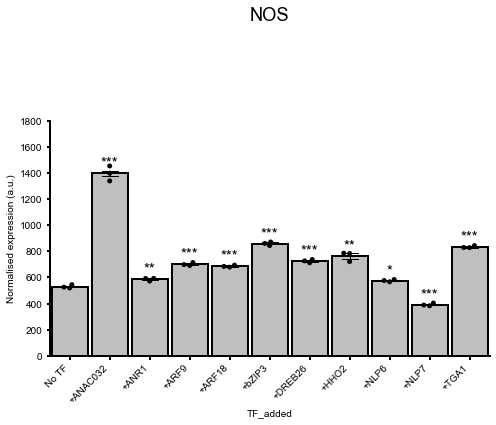

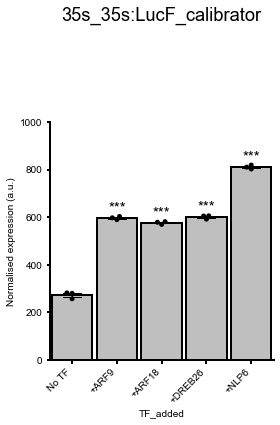

In [37]:
#make experimental design plots other TFs
#layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
#make graphs for each promoter
#color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
#plots for promoters with more than 2 Tf categories
#prom == 'minimal_STAP4'
#set matplotlib default parameters
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['axes.linewidth'] = 2
#rcParams['lines.linewidth'] = 2
#remove top and right lines
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
#font size
fontsize = 18.25
rcParams['font.size'] = fontsize
#for getting the microsoft font Arial working, please follow this guide: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
#allow font to be edited later in pdf editor
rcParams ['pdf.fonttype'] = 42 
#define bar width
bar_width = 0.9
#make svg text editable
rcParams['svg.fonttype'] = 'none'
#align y-axis top most tick with end of axis
rcParams['axes.autolimit_mode'] = 'round_numbers'
#set margins to ensure any error bars fit
rcParams['axes.xmargin'] = 0.2
rcParams['axes.ymargin'] = 0.2

#set width of bars
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


for prom in prom_names_plate1:
    if prom == 'NOS_calibrator' or prom == 'NOS_calibrator_35s:LucF_calibrator' or prom == 'STAP4' or prom == 'minimal_STAP4':
        pass
    #if 35s calibrator in promoter name, skip promoter
    elif prom == '35s_35s:LucF_calibrator':
        df = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
        #df2 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
        #change name of TF added in df2 to minimal_stap4        
        #df2['TF_added'] = 'pSTAP4 no TF'
        #df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
        TFs_orig =  df.TF_added.unique()
        TF_order = ['No TF','+ANAC032','+ANR1','+ARF9','+ARF18','+ARF18+ARF9','+ARF9+IAA33','+ARF18+IAA33','+ARF18+ARF9+IAA33','+bZIP3','+DREB26','+HHO2','+NLP6','+NLP7','+TGA1']
        #new_TF_order = ['No TF','+ARF9','+ARF18','+ARF18+ARF9','+ARF9+IAA33','+ARF18+IAA33','+ARF18+ARF9+IAA33','','No TF_1μM_NAA','+ARF9_1μM_NAA','+ARF18_1μM_NAA','+ARF18+ARF9_1μM_NAA','+ARF9+IAA33_1μM_NAA','+ARF18+IAA33_1μM_NAA','+ARF18+ARF9+IAA33_1μM_NAA']
        #'No TF/YFP','+No TF/YFP_1μM_NAA',
        #sort based on custom order
        TFs = []
        for i in range(len(TF_order)):
            if TF_order[i] in TFs_orig:
                TFs+=[TF_order[i]]
        #print(df)
        #get length of number of TFs
        length_tf = len(TFs)
        #create order and box pairs based on the length of TFs
        order = []
        box_pairs = []   
        for x in range (0, (length_tf)):
            order.append(TFs[x])
            if TFs[x] == "No TF" or TFs[x] == "No TF_1μM_NAA":
                pass
            #if auxin condition, use auxin control
            elif "_1μM_NAA" in TFs[x]:
                box_pairs.append(('No TF_1μM_NAA',TFs[x]))

            else:
                box_pairs.append(('No TF',TFs[x]))
        #add every combination of box pairs of length 2
        #box_pairs=list(combinations(order, 2))~
        #make box pairs dict with box pair and p value
        box_pairs_all_pvalues = {}
        #make dict containing the TF and p value compared to its control (either No TF with auxin or no auxin No TF)
        TFs_pvalues = {}
        for pair in box_pairs:
            #create series objects
            TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
            TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
        # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
        # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
        #equal variance = false so do Welch's T-test
            results = stats.ttest_ind(TF1, TF2, equal_var=False)
            #append pvalue to dict
            box_pairs_all_pvalues[pair] = results.pvalue
            TFs_pvalues[pair[1]] = results.pvalue
            #get mean of each TF in pair
            TF1_mean = TF1.mean()   
            TF2_mean = TF2.mean()
            #get standard deviation of each TF in pair
            TF1_SD = TF1.std()
            TF2_SD = TF2.std()

            with open(f'../../../../data/plots/luminescence/{date}/exp_design/stats.txt', 'a') as f:                       
                f.write(f'{str(prom)},{pair},{results}\nmean of {pair[0]} = {TF1_mean}, mean of {pair[1]} = {TF2_mean}\nSD of {pair[0]} = {TF1_SD}, SD of {pair[1]} = {TF2_SD}\n')
        # box_pairs_significant.append(pair)
        # p_values.append(results.pvalue)
        #print(f'all pvalues={box_pairs_all_pvalues}')

        # #filter dict by significance and put in a new dictionary
        box_pairs_significant = {}
        for k,v in box_pairs_all_pvalues.items():
            if v <0.05:
                box_pairs_significant[k] = v

        def convert_pvalue_to_asterisks(pvalue):
            if pvalue <= 0.001:
                return "***"
            elif pvalue <= 0.01:
                return "**"
            elif pvalue <= 0.05:
                return "*"
            return "ns"
        #print(df.columns)
        #'well', 'content', 'fluc_luminescence', 'nluc_luminescence', 'well_row',
    #    'well_col', 'name', 'condition', 'nluc/fluc', 'date', 'Promoter',
    #    'TF_added', 'Well_calibrator', 'Plate_number',
    #    'corrected_luminescence'
        #add a blank data point in between non-auxin and auxin conditions

        #new_df = pd.concat([df[df.condition == 'nitrogen'], pd.DataFrame({'well':[''],'content':[''],'fluc_luminescence':[0],'nluc_luminescence':[0], 'well_row':[''],'well_col':[0], 'name':[''], 'condition':['nitrogen'], 'nluc/fluc':[0], 'date':[''], 'Promoter':[prom],'TF_added':[''], 'Well_calibrator':[''], 'Plate_number':[0],'corrected_luminescence':[0]}, df[df.condition == '1uM_auxin'])])

        # #rename x values
        # names = df.TF_added.unique()
        # #Change TF names to +TF
        # df_renamed = df.copy()
        # for TF in names:
        #     if '_1μM_NAA' in TF:
        #         new_name = TF[:len(TF)-8]
        #         df_renamed.TF_added.replace(TF,new_name, inplace=True)
        
        # if len(TFs) is 3:
        #     order = [TFs[0],TFs[1],TFs[2]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
        # elif len(TFs) is 4:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
        # elif len(TFs) is 5:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
        # elif len(TFs) is 6:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
        # elif len(TFs) is 7:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
        # elif len(TFs) is 8:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


        if len(TFs) == 2:
            #plt.figure()
            plt.figure(figsize=((length_tf-(length_tf//2)+2),6))
            #order_new = [TFs[0],TFs[1]]
            
            fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2,  errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4, dodge=True,color='#BFBFBF')#facecolor=(1,1,1,1),

            sns.swarmplot(x='TF_added', y='corrected_luminescence',data=df, order=order,color='black',dodge=True,)
            change_width(fig,bar_width)
            #fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order_new)


            # fig = sns.catplot(
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     data=df,
            #     kind='violin',
            #     order=order,            
            #     cut=0,
            #     legend=False,
            #     #color=new_color
            # )
            
            #fig = px.violin(df, x='TF_added',
            #                         y='corrected_luminescence', box=True,                       
            #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

            #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
            #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
            #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
            #hide legend
            #fig.layout.update(showlegend=False)
            # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
            #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
            # label box pairs        
            #box_pairs = [(TFs[0],TFs[1])]
            
            # make empty list of p_values
           # p_values = []
            # populate the list of p_values according to the box_pairs
            # for pair in box_pairs:
            #     print(pair)
            #     # select p value for each pair
            #     p = stat.loc[pair[0], pair[1]]
            #     p_values.append(p)

            # add stats annotation to the plot
            # add_stat_annotation(
            #     fig,
            #     data=df,
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     order=order_new,
            #     box_pairs=list(box_pairs_significant.keys()),
            #     text_format="star",
            #     loc="outside",
            #     verbose=2,
            #     perform_stat_test=False,
            #     pvalues=list(box_pairs_significant.values()),
            #     #test='Mann-Whitney',
            # )
            # # change axes labels
            # plt.ylabel('Normalised expression (a.u.)')
            # #add title
            # plt.title(prom)
            # #make xticks diagonal
            # plt.xticks(rotation=45, ha='right')
            # #plt.xlabel(x_label)
            # # tight layout
            # plt.tight_layout()
            # # save figure
            # plt.savefig(
            #     f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
            #     format="pdf",
            #     bbox_inches="tight",
           # )
        elif len(TFs) < 2:
            pass
        else:
            print(prom)
            print(TFs)
            plt.figure(figsize=((length_tf-(length_tf//2)+1),6))
            # fig = sns.catplot(
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     data=df,
            #     kind='violin',
            #     order=order,            
            #     cut=0,
            #     legend=False,
            #     #color=new_color
            # )
            fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4,dodge=True, color='#BFBFBF') #facecolor=(1,1,1,1)
           
            sns.swarmplot(x='TF_added', y='corrected_luminescence',data=df, order=order,color='black',dodge=True)
            change_width(fig,bar_width)
            #fig = px.violin(df, x='TF_added',
            #                         y='corrected_luminescence', box=True,                       
            #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

            #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
            #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
            #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
            #hide legend
            #fig.layout.update(showlegend=False)
            # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
            # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
            # # label box pairs        
            # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
            # # make empty list of p_values
            # p_values = []
            # # populate the list of p_values according to the box_pairs
            # for pair in box_pairs:
            # #    print(pair)
            #     # select p value for each pair
            #     p = stat.loc[pair[0], pair[1]]
            #     p_values.append(p)

            # add stats annotation to the plot
        #add stats
        #print(box_pairs)
        #if no significant values, don't add stats annotation

        


        # if len(box_pairs_significant.values()) < 1:
        #     pass
        # else:
        #     pass
            # #add a gap between no auxin and auxin conditions
            # #first identify No TF_1μM_NAA X position
            # middle = order.index("No TF_1μM_NAA")
            # #then modify x locations with a gap before the auxin no tf position

            # x_locations = list(range(0,middle))+list(range(middle+1,len(order)+1))
            # print(x_locations)
            # plt.xticks(x_locations,order)
            
            #plt.bar_label(box_pairs_all_pvalues.values())
            #get x length
            xlength=len(fig.patches)
            #print(f'xlength={xlength}')
            #add patterned hatching to the bars length_tf
            #hatches = itertools.cycle(['/','//','+','\\','*','o','O','.'])
            #also add asterisks for p values
            #make empty variable to show when No TF_1μM_NAA has been iterated over
            #auxin_control_picked = False
            for x in range (0, (xlength)):
                current_TF = order[x]
                if current_TF == "No TF" or current_TF == '':                
                    pass
                elif current_TF == "No TF_1μM_NAA":
                    auxin_control_picked = True                    
                   # hatch = next(hatches)
                    fig.patches[x].set_hatch(hatch)
                else:
                    pvalue = TFs_pvalues[current_TF]

                    
                # pvalue = list(box_pairs_all_pvalues.values())[x]
                    #key=list(box_pairs_all_pvalues.keys())[x][1]
                    p = fig.patches[x]
                    fig.annotate(convert_pvalue_to_asterisks(pvalue),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    size=15,
                    xytext = (0, 10), 
                    textcoords = 'offset points')
                    #add patterned hatching to the bars length_tf
                    #if auxin_control_picked == True:
            plt.ylabel('Normalised expression (a.u.)')
            #add title
            plt.title(prom, y=1.4,size=fontsize)
            #make xticks diagonal
            plt.xticks(rotation=45, ha='right')
            #plt.xlabel(x_label)
            # tight layout
            plt.tight_layout()
            # save figure
            plt.savefig(
                f'../../../../data/plots/luminescence/{date}/exp_design/calibrator_35s/scatter{prom}_ARFs_plate1.pdf',
                format="pdf",
                bbox_inches="tight",transparent=True)

            plt.savefig(
                f'../../../../data/plots/luminescence/{date}/exp_design/calibrator_35s/scatter{prom}_ARFs_plate1.svg',
                format="svg",
                bbox_inches="tight",transparent=True)
        
    elif prom == 'NOS':        
          
        df = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
        #df2 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
        #change name of TF added in df2 to minimal_stap4        
        #df2['TF_added'] = 'pSTAP4 no TF'
        #df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
        TFs_orig =  df.TF_added.unique()
        TF_order = ['No TF','+ANAC032','+ANR1','+ARF9','+ARF18','+ARF18+ARF9','+ARF9+IAA33','+ARF18+IAA33','+ARF18+ARF9+IAA33','+bZIP3','+DREB26','+HHO2','+NLP6','+NLP7','+TGA1']
        #new_TF_order = ['No TF','+ARF9','+ARF18','+ARF18+ARF9','+ARF9+IAA33','+ARF18+IAA33','+ARF18+ARF9+IAA33','','No TF_1μM_NAA','+ARF9_1μM_NAA','+ARF18_1μM_NAA','+ARF18+ARF9_1μM_NAA','+ARF9+IAA33_1μM_NAA','+ARF18+IAA33_1μM_NAA','+ARF18+ARF9+IAA33_1μM_NAA']
        #'No TF/YFP','+No TF/YFP_1μM_NAA',
        #sort based on custom order
        TFs = []
        for i in range(len(TF_order)):
            if TF_order[i] in TFs_orig:
                TFs+=[TF_order[i]]
        #print(df)
        #get length of number of TFs
        length_tf = len(TFs)
        #create order and box pairs based on the length of TFs
        order = []
        box_pairs = []   
        for x in range (0, (length_tf)):
            order.append(TFs[x])
            if TFs[x] == "No TF" or TFs[x] == "No TF_1μM_NAA":
                pass
            #if auxin condition, use auxin control
            elif "_1μM_NAA" in TFs[x]:
                box_pairs.append(('No TF_1μM_NAA',TFs[x]))

            else:
                box_pairs.append(('No TF',TFs[x]))
        #add every combination of box pairs of length 2
        #box_pairs=list(combinations(order, 2))~
        #make box pairs dict with box pair and p value
        box_pairs_all_pvalues = {}
        #make dict containing the TF and p value compared to its control (either No TF with auxin or no auxin No TF)
        TFs_pvalues = {}
        for pair in box_pairs:
            #create series objects
            TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
            TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
        # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
        # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
        #equal variance = false so do Welch's T-test
            results = stats.ttest_ind(TF1, TF2, equal_var=False)
            #append pvalue to dict
            box_pairs_all_pvalues[pair] = results.pvalue
            TFs_pvalues[pair[1]] = results.pvalue
            #get mean of each TF in pair
            TF1_mean = TF1.mean()   
            TF2_mean = TF2.mean()
            #get standard deviation of each TF in pair
            TF1_SD = TF1.std()
            TF2_SD = TF2.std()

            with open(f'../../../../data/plots/luminescence/{date}/exp_design/stats.txt', 'a') as f:                       
                f.write(f'{str(prom)},{pair},{results}\nmean of {pair[0]} = {TF1_mean}, mean of {pair[1]} = {TF2_mean}\nSD of {pair[0]} = {TF1_SD}, SD of {pair[1]} = {TF2_SD}\n')
        # box_pairs_significant.append(pair)
        # p_values.append(results.pvalue)
        #print(f'all pvalues={box_pairs_all_pvalues}')

        # #filter dict by significance and put in a new dictionary
        box_pairs_significant = {}
        for k,v in box_pairs_all_pvalues.items():
            if v <0.05:
                box_pairs_significant[k] = v

        def convert_pvalue_to_asterisks(pvalue):
            if pvalue <= 0.001:
                return "***"
            elif pvalue <= 0.01:
                return "**"
            elif pvalue <= 0.05:
                return "*"
            return "ns"
        #print(df.columns)
        #'well', 'content', 'fluc_luminescence', 'nluc_luminescence', 'well_row',
    #    'well_col', 'name', 'condition', 'nluc/fluc', 'date', 'Promoter',
    #    'TF_added', 'Well_calibrator', 'Plate_number',
    #    'corrected_luminescence'
        #add a blank data point in between non-auxin and auxin conditions

        #new_df = pd.concat([df[df.condition == 'nitrogen'], pd.DataFrame({'well':[''],'content':[''],'fluc_luminescence':[0],'nluc_luminescence':[0], 'well_row':[''],'well_col':[0], 'name':[''], 'condition':['nitrogen'], 'nluc/fluc':[0], 'date':[''], 'Promoter':[prom],'TF_added':[''], 'Well_calibrator':[''], 'Plate_number':[0],'corrected_luminescence':[0]}, df[df.condition == '1uM_auxin'])])

        # #rename x values
        # names = df.TF_added.unique()
        # #Change TF names to +TF
        # df_renamed = df.copy()
        # for TF in names:
        #     if '_1μM_NAA' in TF:
        #         new_name = TF[:len(TF)-8]
        #         df_renamed.TF_added.replace(TF,new_name, inplace=True)
        
        # if len(TFs) is 3:
        #     order = [TFs[0],TFs[1],TFs[2]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
        # elif len(TFs) is 4:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
        # elif len(TFs) is 5:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
        # elif len(TFs) is 6:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
        # elif len(TFs) is 7:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
        # elif len(TFs) is 8:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


        if len(TFs) == 2:
            #plt.figure()
            plt.figure(figsize=((length_tf-(length_tf//2)+2),6))
            #order_new = [TFs[0],TFs[1]]
            
            fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2,  errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4, dodge=True,color='#BFBFBF')#facecolor=(1,1,1,1),

            sns.swarmplot(x='TF_added', y='corrected_luminescence',data=df, order=order,color='black',dodge=True,)
            change_width(fig,bar_width)
            #fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order_new)


            # fig = sns.catplot(
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     data=df,
            #     kind='violin',
            #     order=order,            
            #     cut=0,
            #     legend=False,
            #     #color=new_color
            # )
            
            #fig = px.violin(df, x='TF_added',
            #                         y='corrected_luminescence', box=True,                       
            #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

            #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
            #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
            #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
            #hide legend
            #fig.layout.update(showlegend=False)
            # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
            #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
            # label box pairs        
            #box_pairs = [(TFs[0],TFs[1])]
            
            # make empty list of p_values
           # p_values = []
            # populate the list of p_values according to the box_pairs
            # for pair in box_pairs:
            #     print(pair)
            #     # select p value for each pair
            #     p = stat.loc[pair[0], pair[1]]
            #     p_values.append(p)

            # add stats annotation to the plot
            # add_stat_annotation(
            #     fig,
            #     data=df,
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     order=order_new,
            #     box_pairs=list(box_pairs_significant.keys()),
            #     text_format="star",
            #     loc="outside",
            #     verbose=2,
            #     perform_stat_test=False,
            #     pvalues=list(box_pairs_significant.values()),
            #     #test='Mann-Whitney',
            # )
            # # change axes labels
            # plt.ylabel('Normalised expression (a.u.)')
            # #add title
            # plt.title(prom)
            # #make xticks diagonal
            # plt.xticks(rotation=45, ha='right')
            # #plt.xlabel(x_label)
            # # tight layout
            # plt.tight_layout()
            # # save figure
            # plt.savefig(
            #     f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
            #     format="pdf",
            #     bbox_inches="tight",
           # )
        elif len(TFs) < 2:
            pass
        else:
            print(prom)
            print(TFs)
            plt.figure(figsize=((length_tf-(length_tf//2)+1),6))
            # fig = sns.catplot(
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     data=df,
            #     kind='violin',
            #     order=order,            
            #     cut=0,
            #     legend=False,
            #     #color=new_color
            # )
            fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2,  errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4,dodge=True,color='#BFBFBF')#facecolor=(1,1,1,1),
           
            sns.swarmplot(x='TF_added', y='corrected_luminescence',data=df, order=order,color='black',dodge=True)
            change_width(fig,bar_width)
            
            #fig = px.violin(df, x='TF_added',
            #                         y='corrected_luminescence', box=True,                       
            #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

            #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
            #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
            #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
            #hide legend
            #fig.layout.update(showlegend=False)
            # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
            # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
            # # label box pairs        
            # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
            # # make empty list of p_values
            # p_values = []
            # # populate the list of p_values according to the box_pairs
            # for pair in box_pairs:
            # #    print(pair)
            #     # select p value for each pair
            #     p = stat.loc[pair[0], pair[1]]
            #     p_values.append(p)

            # add stats annotation to the plot
        #add stats
        #print(box_pairs)
        #if no significant values, don't add stats annotation

        


        # if len(box_pairs_significant.values()) < 1:
        #     pass
        # else:
        #     pass
            # #add a gap between no auxin and auxin conditions
            # #first identify No TF_1μM_NAA X position
            # middle = order.index("No TF_1μM_NAA")
            # #then modify x locations with a gap before the auxin no tf position

            # x_locations = list(range(0,middle))+list(range(middle+1,len(order)+1))
            # print(x_locations)
            # plt.xticks(x_locations,order)
            
            #plt.bar_label(box_pairs_all_pvalues.values())
            #get x length
            xlength=len(fig.patches)
            #print(f'xlength={xlength}')
            #add patterned hatching to the bars length_tf
            #hatches = itertools.cycle(['/','//','+','\\','*','o','O','.'])
            #also add asterisks for p values
            #make empty variable to show when No TF_1μM_NAA has been iterated over
            #auxin_control_picked = False
            for x in range (0, (xlength)):
                current_TF = order[x]
                if current_TF == "No TF" or current_TF == '':                
                    pass
                elif current_TF == "No TF_1μM_NAA":
                    auxin_control_picked = True                    
                   # hatch = next(hatches)
                    fig.patches[x].set_hatch(hatch)
                else:
                    pvalue = TFs_pvalues[current_TF]

                    
                # pvalue = list(box_pairs_all_pvalues.values())[x]
                    #key=list(box_pairs_all_pvalues.keys())[x][1]
                    p = fig.patches[x]
                    fig.annotate(convert_pvalue_to_asterisks(pvalue),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    size=15,
                    xytext = (0, 10), 
                    textcoords = 'offset points')
                    #add patterned hatching to the bars length_tf
                    #if auxin_control_picked == True:
            plt.ylabel('Normalised expression (a.u.)')
            #add title
            plt.title(prom, y=1.4,size=fontsize)
            #make xticks diagonal
            plt.xticks(rotation=45, ha='right')
            #plt.xlabel(x_label)
            # tight layout
            plt.tight_layout()
            # save figure
            plt.savefig(
                f'../../../../data/plots/luminescence/{date}/exp_design/calibrator_nos/scatter{prom}_experimental_design_plate1.pdf',
                format="pdf",
                bbox_inches="tight",transparent=True)

            plt.savefig(
                f'../../../../data/plots/luminescence/{date}/exp_design/calibrator_nos/scatter{prom}_experimental_design_plate1.svg',
                format="svg",
                bbox_inches="tight",transparent=True)

                           # p.set_hatch(hatch)
             
            # hatches = itertools.cycle(['/','//','+','\\','*','o','O','.'])
            # for i, bar in enumerate(fig.patches):
            #     print(f'i={i},bar={bar}')
            #     if i % length_tf == 0:
            #         hatch = next(hatches)
            #     bar.set_hatch(hatch)
            # y_position = df['corrected_luminescence'].max()
            # for k, v in box_pairs_all_pvalues.items():
            #     plt.text(x=k[1], y=y_position, s=convert_pvalue_to_asterisks(v))
            # #annotator = Annotator(fig, pairs=list(box_pairs), data=df, x='TF_added', y='corrected_luminescence',order=order,)
            # annotator = Annotator(fig, pairs=list(box_pairs_significant.keys()), data=df, x='TF_added', y='corrected_luminescence',order=order,)
            # #annotator.set_pvalues(list(box_pairs))
            # annotator.set_pvalues(list(box_pairs_significant.values()))
            # #annotator.configure(test='Mann-Whitney',verbose=2,text_format='star', loc='inside',)#loc='inside'
            # #annotator.apply_and_annotate()
            # annotator.annotate()


            #if no significant values, don't add stats annotation
        # if len(box_pairs_significant.values()) < 1:
        #     pass
        # else:
        #     add_stat_annotation(
        #         fig,
        #         data=df,
        #         x='TF_added',
        #         y='corrected_luminescence',
        #         order=order,
        #         box_pairs=list(box_pairs_significant.keys()),
        #         text_format="star",
        #         loc="outside",
        #         verbose=2,
        #         perform_stat_test=False,
        #         pvalues=list(box_pairs_significant.values()),
        #         #test_short_name="Dunn",
        #     )
                #change name of promoters

        #add custom legend
        # handles = []
        # labels = []
        # no_auxin = mpatches.Patch(facecolor='white', hatch='',edgecolor='black',linewidth=2)
        # auxin = mpatches.Patch(facecolor='white', hatch='/',edgecolor='black',linewidth=2)
        # no_auxin_label = "No NAA"
        # auxin_label = "1 µM NAA"
        # handles.append(no_auxin)
        # handles.append(auxin)
        # labels.append(no_auxin_label)
        # labels.append(auxin_label)
        # fig.legend(handles=handles,labels=labels,ncol=1,bbox_to_anchor=(0.1,1), loc='lower left',fontsize=14)
        
        # new_labels = []        
        # for TF in order:
        #     if '_1μM_NAA' in TF:
        #         TFs_orig_renamed = TF[:len(TF)-8]
        #         new_labels.append(TFs_orig_renamed)
        #     else:
        #         new_labels.append(TF)
                
        #fig.set_xticklabels(new_labels)
        # change axes labels
       
 
            


            #write to file static image and interactive one
        # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
        #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
        #  fig.show()

prom=35s_35s:LucF_calibratorpair=[('No TF', '+NLP6')]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

No TF vs. +NLP6: Welch's t-test independent samples, P_val:5.041e-06 t=-5.826e+01
prom=35s_35s:LucF_calibratorpair=[('No TF', '+DREB26')]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

No TF vs. +DREB26: Welch's t-test independent samples, P_val:3.136e-05 t=-3.600e+01
prom=35s_35s:LucF_calibratorpair=[('No TF', '+ARF9')]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

No TF vs. +ARF9: Welch's t-test independent samples, P_val:6.026e-05 t=-3.672e+01
prom=35s_35s:LucF_calibratorpair=[('No TF', '+ARF18')]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **:

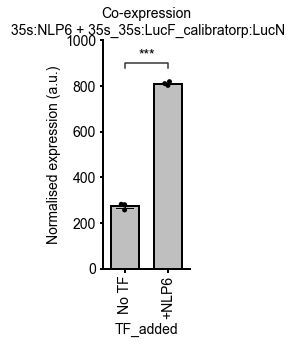

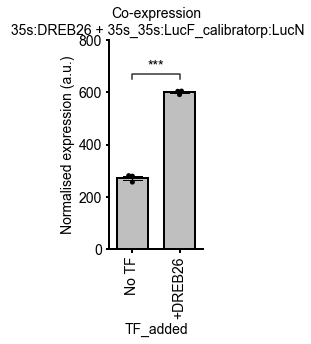

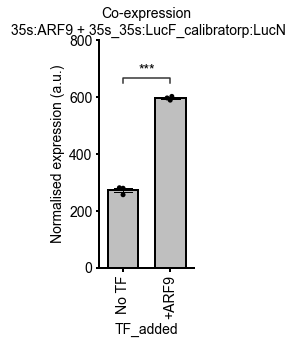

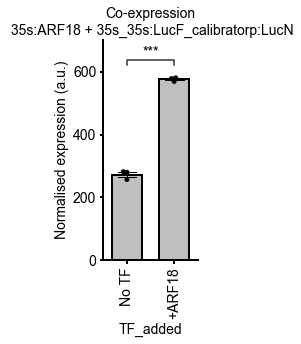

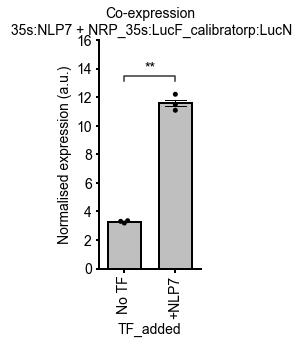

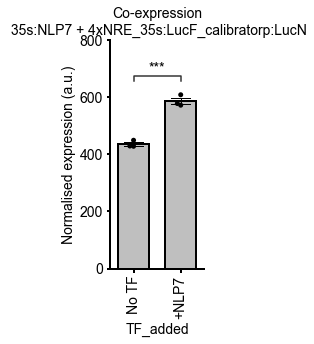

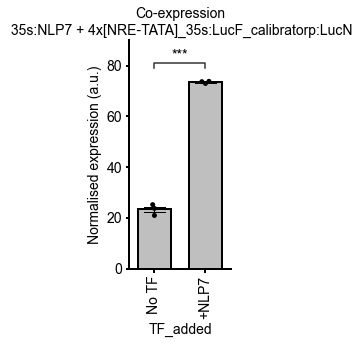

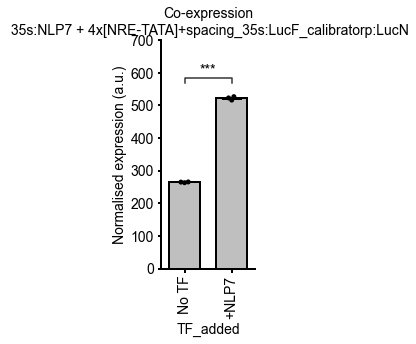

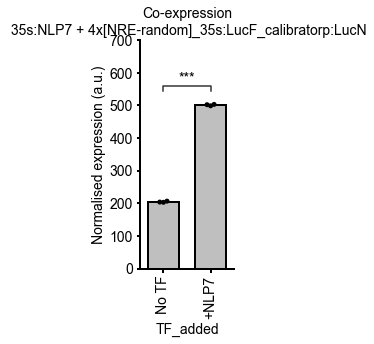

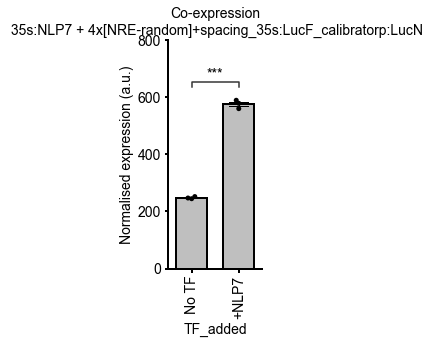

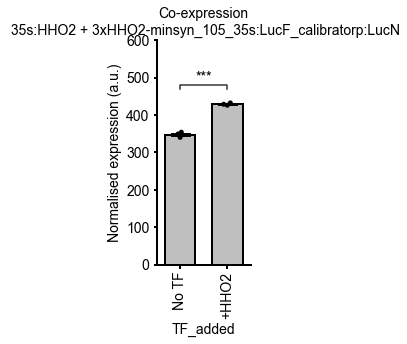

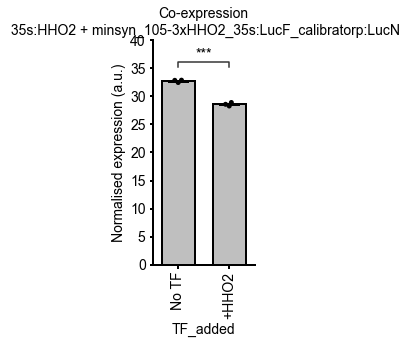

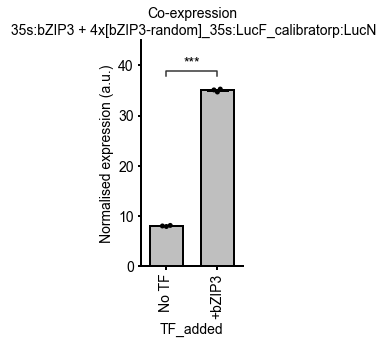

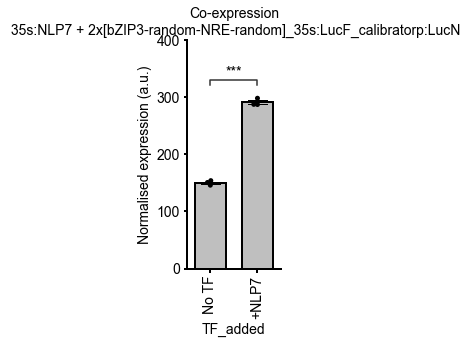

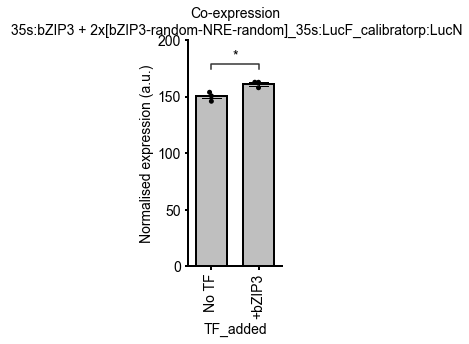

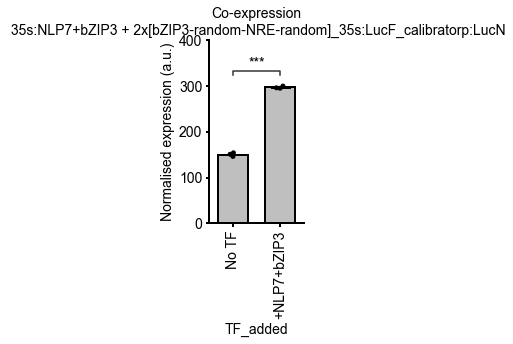

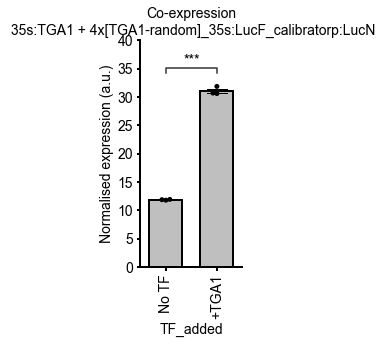

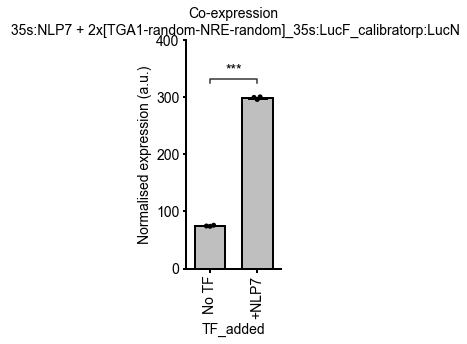

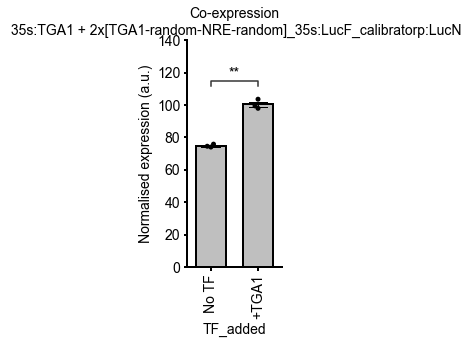

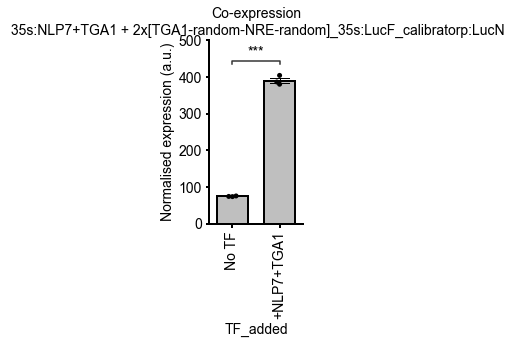

In [38]:
#make individual plots
#layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
#make graphs for each promoter
#color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
#plots for promoters with more than 2 Tf categories
#prom == 'minimal_STAP4'
#set matplotlib default parameters
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['axes.linewidth'] = 2
#rcParams['lines.linewidth'] = 2
#remove top and right lines
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
#font size
fontsize = 14
rcParams['font.size'] = fontsize
#for getting the microsoft font Arial working, please follow this guide: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
#allow font to be edited later in pdf editor
rcParams ['pdf.fonttype'] = 42
#make svg text editable
rcParams['svg.fonttype'] = 'none'
#align y-axis top most tick with end of axis
rcParams['axes.autolimit_mode'] = 'round_numbers'
#set margins to ensure any error bars fit
rcParams['axes.xmargin'] = 0.2
rcParams['axes.ymargin'] = 0.2
#define bar width
bar_width = 0.65
#plot height and width
height = 5
width = 2.4
#delete the stats file if it exists
stats_file = f'../../../../data/plots/luminescence/{date}/individual/stats.txt'    
if os.path.exists(stats_file):
    os.remove(stats_file)
#set width of bars
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

for prom in prom_names_plate1:
    if prom == 'NOS_calibrator' or prom == 'STAP4' or prom == 'NOS' or prom == 'minimal_STAP4' or prom == 'NOS_calibrator_35s:LucF_calibrator' or prom == 'NRP:NLUC:YFP' or prom == 'NIR1:NLUC:YFP' or prom == '35s:NLUC:YFP' or prom == '4x[NRE-TATA]+spacing:NLUC:YFP' or prom == '4x[bZIP3-random]:NLUC:YFP' or prom == '35s:NLUC:YFP_nomarker':
        pass
    else:
        df = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
        #split based on well calibrator
        if "_35s:LucF_calibrator" in prom:
            #get list of TFs coexpressed with that promoter
            TFs_orig =  df.TF_added.unique()
            #assign list of TFs of interest with this well calibrator
            TF_order = ['No TF','+ANAC032','+NLP6','+NLP7','+DREB26','+HHO2','+bZIP3','+ANR1','+ARF9','+ARF18','+TGA1','+NLP7+bZIP3','+NLP7+TGA1']

            #sort based on custom order
            TFs = []
            for i in range(len(TF_order)):
                if TF_order[i] in TFs_orig:
                    TFs+=[TF_order[i]]

            if len(TFs) < 2:
                pass
            else:
                for TF in TFs:
                    if TF == 'No TF':
                        pass
                    else:
                        
                        
                        #create new df with only TF of interest
                        df_new = df[(df.TF_added == TF) | (df.TF_added == 'No TF')]
                        #create box pairs
                        pair = [('No TF', TF)]
                        print(f'prom={prom}pair={pair}')
                        #pvalue = []
                    
                        # #create series objects
                        # TF1 = df_new.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
                        # TF2 = df_new.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
                        # # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
                        # # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
                        # #equal variance = false so do Welch's T-test
                        # results = stats.ttest_ind(TF1, TF2, equal_var=False)
                        #     #append pvalue to dict
                        # pvalue = results.pvalue
                        # # box_pairs_significant.append(pair)
                        # # p_values.append(results.pvalue)
                        # print(f'pvalue={pvalue}')

                        # # #filter dict by significance and put in a new dictionary
                        # # box_pairs_significant = {}
                        # # for k,v in box_pairs_all_pvalues.items():
                        # #     if v <0.05:
                        # #         box_pairs_significant[k] = v
                        


                        #make plot 
                        plt.figure(figsize=(width,height))
                        
                        order_new = pair[0]
                        fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df_new, order=order_new, linewidth=2,  errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4,color='#BFBFBF')#facecolor=(1,1,1,1),
                        #fig.set_aspect(0.5)
                        sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df_new, order=order_new,color='black')
                        #change bar width
                        change_width(fig, bar_width)
                        #add stats
                        annotator = Annotator(fig, pair, data=df_new, x='TF_added', y='corrected_luminescence',order=order_new)
                        annotator.configure(test='t-test_welch', text_format='star',pvalue_thresholds=[[1e-3, "***"],[1e-2, "**"],[0.05, "*"],[1, "ns"]])#loc='inside'
                        # annotator.apply_and_annotate()
                        ax, test_results = annotator.apply_and_annotate()
                        # annotator.apply_and_annotate()
                        #write stats to file
                        with open(f'../../../../data/plots/luminescence/{date}/individual/stats.txt', 'a') as f:                            
                            for res in test_results:                    
                                f.write(f'{str(prom)},{str(res.data.group1)},{str(res.data.group2)},{str(res.data)},t={res.data.stat_value}, P={res.data.pvalue}\n{res.structs} \n\n') 



                        # if pvalue<0.05:

                        #     add_stat_annotation(
                        #     fig,
                        #     data=df_new,
                        #     x='TF_added',
                        #     y='corrected_luminescence',
                        #     order=order_new,
                        #     box_pairs=pair,
                        #     text_format="star",
                        #     loc="inside",
                        #     verbose=2,
                        #     perform_stat_test=False,
                        #     pvalues=list(pvalue),
                        #     #test='Mann-Whitney'
                        #     #test_short_name="Dunn",
                        #     )

                        # change axes labels
                        plt.ylabel('Normalised expression (a.u.)')
                        #add title

                        #plt.title(prom[:len(prom)-20], y=1,size=fontsize)
                        plt.title(f'Co-expression\n 35s:{TF[1:]} + {prom}p:LucN', y=1,size=fontsize)
                        
                        #make xticks diagonal
                        plt.xticks(rotation=90, ha='center')#ha='right'
                        #plt.xlabel(x_label)
                        # tight layout
                        plt.tight_layout()
                        # save figure
                        plt.savefig(
                            f'../../../../data/plots/luminescence/{date}/individual/calibrator_35s/scatter{prom}_{TF}_plate1.pdf',
                            format="pdf",
                            bbox_inches="tight",transparent=True)
                        plt.savefig(
                            f'../../../../data/plots/luminescence/{date}/individual/calibrator_35s/scatter{prom}_{TF}_plate1.svg',
                            format="svg",
                            bbox_inches="tight",transparent=True)

        else:          
            #df2 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
            #change name of TF added in df2 to minimal_stap4        
            #df2['TF_added'] = 'pSTAP4 no TF'
            # df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
            TFs_orig =  df.TF_added.unique()
            #print(TFs_orig)
            TF_order = ['No TF','+ANR1','+bZIP3','+DREB26','+HHO2','+NLP6','+TGA1','+TGA1:GR','+bZIP3','+DREB26','+HHO2','+NLP6','+NLP7','+TGA1','+NLP7+bZIP3','+NLP7+TGA1','No TF nor YFP', 'No TF', '+TAD-Suntag_noguide','+TAD-Suntag_guide1','+TAD-Suntag_guides1,2,3','+VP64-Suntag_noguide','+VP64-Suntag_guide1','+VP64-Suntag_guides1,2,3','+SRDX-dCpf1_noguide','+SRDX-dCpf1_guide1','+SRDX-dCpf1_guide2','+SRDX-dCpf1_guide3','+SRDX-dCpf1_guides1,2,3','+SRDX-dCpf1_guides1,2,4','+SRDX-Suntag_noguide','+SRDX-Suntag_123guides1,2,3']
            #'No TF/YFP','+No TF/YFP_1μM_NAA',
            #sort based on custom order
            TFs = []
            for i in range(len(TF_order)):
                if TF_order[i] in TFs_orig:
                    TFs+=[TF_order[i]]
            #print(TFs)
            #print(df)
            #get length of number of TFs
            #length_tf = len(TFs)
            #create order and box pairs based on the length of TFs
            #iterate through TFs
            #pass if only one TF
            if len(TFs) < 2:
                pass
            else:
                for TF in TFs:
                    if TF == 'No TF':
                        pass
                    else:
                        
                        
                        #create new df with only TF of interest
                        df_new = df[(df.TF_added == TF) | (df.TF_added == 'No TF')]
                        #create box pairs
                        pair = [('No TF', TF)]
                        print(pair)
                        #pvalue = []
                    
                        # #create series objects
                        # TF1 = df_new.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
                        # TF2 = df_new.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
                        # # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
                        # # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
                        # #equal variance = false so do Welch's T-test
                        # results = stats.ttest_ind(TF1, TF2, equal_var=False)
                        #     #append pvalue to dict
                        # pvalue = results.pvalue
                        # # box_pairs_significant.append(pair)
                        # # p_values.append(results.pvalue)
                        # print(f'pvalue={pvalue}')

                        # # #filter dict by significance and put in a new dictionary
                        # # box_pairs_significant = {}
                        # # for k,v in box_pairs_all_pvalues.items():
                        # #     if v <0.05:
                        # #         box_pairs_significant[k] = v
                        
                        #make plot 
                        if TF == '+TAD-Suntag_noguide' or TF == '+TAD-Suntag_guide1' or TF == '+TAD-Suntag_guides1,2,3' or TF == '+VP64-Suntag_noguide' or TF == '+VP64-Suntag_guide1' or TF == '+VP64-Suntag_guides1,2,3' or TF == '+SRDX-dCpf1_noguide' or TF == '+SRDX-dCpf1_guide1' or TF == '+SRDX-dCpf1_guide2' or TF == '+SRDX-dCpf1_guide3' or TF == '+SRDX-dCpf1_guides1,2,3' or TF == '+SRDX-dCpf1_guides1,2,4' or TF == '+SRDX-Suntag_noguide' or TF == '+SRDX-Suntag_123guides1,2,3':

                            plt.figure(figsize=(6,6))

                        else:
                            plt.figure(figsize=(width,height))
                        order_new = pair[0]
                        fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df_new, order=order_new, linewidth=2, errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4,color='#BFBFBF')#facecolor=(1,1,1,1)
                        #fig.set_aspect(0.5)
                        sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df_new, order=order_new,color='black')
                        #change bar width
                        change_width(fig, bar_width)

                        #add stats

                        annotator = Annotator(fig, pair, data=df_new, x='TF_added', y='corrected_luminescence',order=order_new)
                        annotator.configure(test='t-test_welch', text_format='star',pvalue_thresholds=[[1e-3, "***"],[1e-2, "**"],[0.05, "*"],[1,"ns"]])#loc='inside'
                         #add stats
                        ax, test_results = annotator.apply_and_annotate()
                        # annotator.apply_and_annotate()
                        #write stats to file
                        with open(f'../../../../data/plots/luminescence/{date}/individual/stats.txt', 'a') as f:                            
                            for res in test_results:                    
                                f.write(f'{str(prom)},{str(res.data.group1)},{str(res.data.group2)},{str(res.data)},t={res.data.stat_value}, P={res.data.pvalue}\n{res.structs} \n\n') 
                        



                        # if pvalue<0.05:

                        #     add_stat_annotation(
                        #     fig,
                        #     data=df_new,
                        #     x='TF_added',
                        #     y='corrected_luminescence',
                        #     order=order_new,
                        #     box_pairs=pair,
                        #     text_format="star",
                        #     loc="inside",
                        #     verbose=2,
                        #     perform_stat_test=False,
                        #     pvalues=list(pvalue),
                        #     #test='Mann-Whitney'
                        #     #test_short_name="Dunn",
                        #     )

                        # change axes labels
                        plt.ylabel('Normalised expression (a.u.)')
                        #add title
                        if TF == '+TAD-Suntag_noguide' or TF == '+TAD-Suntag_guide1' or TF == '+TAD-Suntag_guides1,2,3' or TF == '+VP64-Suntag_noguide' or TF == '+VP64-Suntag_guide1' or TF == '+VP64-Suntag_guides1,2,3' or TF == '+SRDX-dCpf1_noguide' or TF == '+SRDX-dCpf1_guide1' or TF == '+SRDX-dCpf1_guide2' or TF == '+SRDX-dCpf1_guide3' or TF == '+SRDX-dCpf1_guides1,2,3' or TF == '+SRDX-dCpf1_guides1,2,4' or TF == '+SRDX-Suntag_noguide' or TF == '+SRDX-Suntag_123guides1,2,3':
                            pass
                        else:
                            plt.title(f'Co-expression\n 35s:{TF[1:]} + {prom}p:LucN', y=1,size=fontsize)
                        #make xticks diagonal
                        plt.xticks(rotation=90, ha='center')#ha='right'
                        #plt.xlabel(x_label)
                        # tight layout
                        plt.tight_layout()
                        # save figure
                        plt.savefig(
                            f'../../../../data/plots/luminescence/{date}/individual/calibrator_nos/scatter{prom}_{TF}_plate1.pdf',
                            format="pdf",
                            bbox_inches="tight",transparent=True)
                        plt.savefig(
                            f'../../../../data/plots/luminescence/{date}/individual/calibrator_nos/scatter{prom}_{TF}_plate1.svg',
                            format="svg",
                            bbox_inches="tight",transparent=True)

                

            
            
            



In [ ]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
# #plots for promoters with more than 2 Tf categories
# #prom == 'minimal_STAP4'
# #set matplotlib default parameters
# rcParams['xtick.major.width'] = 2
# rcParams['ytick.major.width'] = 2
# rcParams['axes.linewidth'] = 2
# #rcParams['lines.linewidth'] = 2
# #remove top and right lines
# rcParams['axes.spines.top'] = False
# rcParams['axes.spines.right'] = False
# #font size
# rcParams['font.size'] = 16
# for prom in prom_names_plate1:
#     if prom == 'NOS_calibrator' or prom == 'STAP4' or prom == 'NOS' or prom == 'minimal_STAP4':
#         pass
#     else:
#         df1 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
#         df2 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
#         #change name of TF added in df2 to minimal_stap4        
#         df2['TF_added'] = 'pSTAP4 no TF'
#         df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
#         TFs_orig =  df.TF_added.unique()
#         TF_order = ['No TF','+No TF_1μM_NAA','+YFP','+YFP_1μM_NAA','+ANAC032','+ANR1','+ARF18','+ARF18_1μM_NAA','+ARF9','+ARF9_1μM_NAA','+ARF18+ARF9','+ARF18+ARF9_1μM_NAA','+bZIP3','+DREB26','+HHO2','+NLP6','+NLP7','+TGA1','+NLP7+bZIP3','+NLP7+TGA1']
#         #sort based on custom order
#         TFs = []
#         for i in range(len(TF_order)):
#             if TF_order[i] in TFs_orig:
#                 TFs+=[TF_order[i]]
#         #print(df)
#         #get length of number of TFs
#         length_tf = len(TFs)
#         #create order and box pairs based on the length of TFs
#         order = []
#         box_pairs = []   
#         for x in range (0, (length_tf)):
#             order.append(TFs[x])
#             if TFs[x] == "+YFP":
#                 pass
#             else:
#                 box_pairs.append(('+YFP',TFs[x]))
#         #add every combination of box pairs of length 2
#         #box_pairs=list(combinations(order, 2))~
#         box_pairs_all_pvalues = {}
#         for pair in box_pairs:
#             #create series objects
#             TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
#             TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
#         # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
#         # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
#         #equal variance = false so do Welch's T-test
#             results = stats.ttest_ind(TF1, TF2, equal_var=False)
#             #append pvalue to dict
#             box_pairs_all_pvalues[pair] = results.pvalue
#         # box_pairs_significant.append(pair)
#         # p_values.append(results.pvalue)
#         print(f'all pvalues={box_pairs_all_pvalues}')

#         # #filter dict by significance and put in a new dictionary
#         box_pairs_significant = {}
#         for k,v in box_pairs_all_pvalues.items():
#             if v <0.05:
#                 box_pairs_significant[k] = v
                

        
#         # if len(TFs) is 3:
#         #     order = [TFs[0],TFs[1],TFs[2]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
#         # elif len(TFs) is 4:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
#         # elif len(TFs) is 5:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
#         # elif len(TFs) is 6:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
#         # elif len(TFs) is 7:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
#         # elif len(TFs) is 8:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


#         if len(TFs) == 2:
#             #plt.figure()
#             plt.figure(figsize=((length_tf-(length_tf//2)+2),6))
#             order_new = [TFs[0],TFs[1]]
#             fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, facecolor=(1,1,1,1), errcolor=".2", edgecolor=".2", ci=68, errwidth=1,capsize=0.4)
#             sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, order=order,color='black')
#             #fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order_new)


#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
            
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # label box pairs        
#             #box_pairs = [(TFs[0],TFs[1])]
            
#             # make empty list of p_values
#            # p_values = []
#             # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             #     print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)

#             # add stats annotation to the plot
#             # add_stat_annotation(
#             #     fig,
#             #     data=df,
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     order=order_new,
#             #     box_pairs=list(box_pairs_significant.keys()),
#             #     text_format="star",
#             #     loc="outside",
#             #     verbose=2,
#             #     perform_stat_test=False,
#             #     pvalues=list(box_pairs_significant.values()),
#             #     #test='Mann-Whitney',
#             # )
#             # # change axes labels
#             # plt.ylabel('Normalised expression (a.u.)')
#             # #add title
#             # plt.title(prom)
#             # #make xticks diagonal
#             # plt.xticks(rotation=45, ha='right')
#             # #plt.xlabel(x_label)
#             # # tight layout
#             # plt.tight_layout()
#             # # save figure
#             # plt.savefig(
#             #     f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
#             #     format="pdf",
#             #     bbox_inches="tight",
#            # )
#         elif len(TFs) < 2:
#             pass
#         else:
#             print(prom)
#             print(TFs)
#             plt.figure(figsize=((length_tf-(length_tf//2)+1),6))
#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
#             fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, facecolor=(1,1,1,1), errcolor=".2", edgecolor=".2", ci=68, errwidth=1,capsize=0.4)
#             sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, order=order,color='black')
            
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # # label box pairs        
#             # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
#             # # make empty list of p_values
#             # p_values = []
#             # # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             # #    print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)

#             # add stats annotation to the plot
#             #if no significant values, don't add stats annotation
#         if len(box_pairs_significant.values()) < 1:
#             pass
#         else:
#             add_stat_annotation(
#                 fig,
#                 data=df,
#                 x='TF_added',
#                 y='corrected_luminescence',
#                 order=order,
#                 box_pairs=list(box_pairs_significant.keys()),
#                 text_format="star",
#                 loc="outside",
#                 verbose=2,
#                 perform_stat_test=False,
#                 pvalues=list(box_pairs_significant.values()),
#                 #test_short_name="Dunn",
#             )
#         # change axes labels
#         plt.ylabel('Normalised expression (a.u.)')
#         #add title
#         plt.title(prom, y=1.4,)
#         #make xticks diagonal
#         plt.xticks(rotation=45, ha='right')
#         #plt.xlabel(x_label)
#         # tight layout
#         plt.tight_layout()
#         # save figure
#         plt.savefig(
#             f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
#             format="pdf",
#             bbox_inches="tight",)
 
            


#             #write to file static image and interactive one
#         # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#         #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#         #  fig.show()

: 

In [ ]:
#make ARF plots
#layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
#make graphs for each promoter
#color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
#plots for promoters with more than 2 Tf categories
#prom == 'minimal_STAP4'
#set matplotlib default parameters
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['axes.linewidth'] = 2
#rcParams['lines.linewidth'] = 2
#remove top and right lines
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
#font size
fontsize = 24
rcParams['font.size'] = fontsize
#for getting the microsoft font Arial working, please follow this guide: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
#allow font to be edited later in pdf editor
rcParams ['pdf.fonttype'] = 42
#make svg text editable
rcParams['svg.fonttype'] = 'none'
#align y-axis top most tick with end of axis
rcParams['axes.autolimit_mode'] = 'round_numbers'
#set margins to ensure any error bars fit
rcParams['axes.xmargin'] = 0.2
rcParams['axes.ymargin'] = 0.2
#define bar width
bar_width = 0.65

#set width of bars
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


for prom in prom_names_plate1:
    if prom == 'NOS_calibrator' or prom == 'NOS_calibrator_35s:LucF_calibrator' or prom == 'STAP4' or prom == 'NOS' or prom == 'minimal_STAP4' or prom == 'ARF18' or prom == 'ANR1' or prom == 'ANAC032' or prom =='NIR1' or prom == 'NLP6' or prom == '35s:NLUC:YFP' or prom == 'NRP:NLUC:YFP' or prom == '35s:NLUC:YFP_nomarker' or prom == '4x[bZIP3-random]:NLUC:YFP' or prom =='DREB26' or prom == 'NLP7' or prom =='ANAC032_ablated_TGA1_all_sites':
        pass
    #if 35s calibrator in promoter name, skip promoter
    #elif "_35s:LucF_calibrator" in prom:
        #pass
    else:        
          
        df = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
        #df2 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
        #change name of TF added in df2 to minimal_stap4        
        #df2['TF_added'] = 'pSTAP4 no TF'
        #df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
        TFs_orig =  df.TF_added.unique()
        TF_order = ['No TF','+ARF9','+ARF18','+ARF18+ARF9','+ARF9+IAA33','+ARF18+IAA33','+ARF18+ARF9+IAA33','No TF_1μM_NAA','+ARF9_1μM_NAA','+ARF18_1μM_NAA','+ARF18+ARF9_1μM_NAA','+ARF9+IAA33_1μM_NAA','+ARF18+IAA33_1μM_NAA','+ARF18+ARF9+IAA33_1μM_NAA']
        #new_TF_order = ['No TF','+ARF9','+ARF18','+ARF18+ARF9','+ARF9+IAA33','+ARF18+IAA33','+ARF18+ARF9+IAA33','','No TF_1μM_NAA','+ARF9_1μM_NAA','+ARF18_1μM_NAA','+ARF18+ARF9_1μM_NAA','+ARF9+IAA33_1μM_NAA','+ARF18+IAA33_1μM_NAA','+ARF18+ARF9+IAA33_1μM_NAA']
        #'No TF/YFP','+No TF/YFP_1μM_NAA',
        #sort based on custom order
        TFs = []
        for i in range(len(TF_order)):
            if TF_order[i] in TFs_orig:
                TFs+=[TF_order[i]]
        #print(df)
        #get length of number of TFs
        length_tf = len(TFs)
        if len(TFs) <= 1:
            pass
        else:
            #create order and box pairs based on the length of TFs
            order = []
            box_pairs = []   
            for x in range (0, (length_tf)):
                order.append(TFs[x])
                if TFs[x] == "No TF" or TFs[x] == "No TF_1μM_NAA":
                    pass
                #if auxin condition, use auxin control
                elif "_1μM_NAA" in TFs[x]:
                    box_pairs.append(('No TF_1μM_NAA',TFs[x]))

                else:
                    box_pairs.append(('No TF',TFs[x]))
            #add every combination of box pairs of length 2
            #box_pairs=list(combinations(order, 2))~
            #make box pairs dict with box pair and p value
            box_pairs_all_pvalues = {}
            #make dict containing the TF and p value compared to its control (either No TF with auxin or no auxin No TF)
            TFs_pvalues = {}
            for pair in box_pairs:
                #create series objects
                TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
                TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
            # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
            # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
            #equal variance = false so do Welch's T-test
                results = stats.ttest_ind(TF1, TF2, equal_var=False)
                #append pvalue to dict
                box_pairs_all_pvalues[pair] = results.pvalue
                TFs_pvalues[pair[1]] = results.pvalue
            # box_pairs_significant.append(pair)
            # p_values.append(results.pvalue)
            #print(f'all pvalues={box_pairs_all_pvalues}')

            # #filter dict by significance and put in a new dictionary
            box_pairs_significant = {}
            for k,v in box_pairs_all_pvalues.items():
                if v <0.05:
                    box_pairs_significant[k] = v

            def convert_pvalue_to_asterisks(pvalue):
                if pvalue <= 0.001:
                    return "***"
                elif pvalue <= 0.01:
                    return "**"
                elif pvalue <= 0.05:
                    return "*"
                return "ns"
            #print(df.columns)
            #'well', 'content', 'fluc_luminescence', 'nluc_luminescence', 'well_row',
        #    'well_col', 'name', 'condition', 'nluc/fluc', 'date', 'Promoter',
        #    'TF_added', 'Well_calibrator', 'Plate_number',
        #    'corrected_luminescence'
            #add a blank data point in between non-auxin and auxin conditions

            #new_df = pd.concat([df[df.condition == 'nitrogen'], pd.DataFrame({'well':[''],'content':[''],'fluc_luminescence':[0],'nluc_luminescence':[0], 'well_row':[''],'well_col':[0], 'name':[''], 'condition':['nitrogen'], 'nluc/fluc':[0], 'date':[''], 'Promoter':[prom],'TF_added':[''], 'Well_calibrator':[''], 'Plate_number':[0],'corrected_luminescence':[0]}, df[df.condition == '1uM_auxin'])])

            # #rename x values
            # names = df.TF_added.unique()
            # #Change TF names to +TF
            # df_renamed = df.copy()
            # for TF in names:
            #     if '_1μM_NAA' in TF:
            #         new_name = TF[:len(TF)-8]
            #         df_renamed.TF_added.replace(TF,new_name, inplace=True)
            
            # if len(TFs) is 3:
            #     order = [TFs[0],TFs[1],TFs[2]]
            #     # label box pairs
            #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
            # elif len(TFs) is 4:
            #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
            #     # label box pairs
            #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
            # elif len(TFs) is 5:
            #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
            #     # label box pairs
            #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
            # elif len(TFs) is 6:
            #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
            #     # label box pairs
            #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
            # elif len(TFs) is 7:
            #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
            #     # label box pairs
            #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
            # elif len(TFs) is 8:
            #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
            #     # label box pairs
            #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
                


            if len(TFs) == 2:
                #plt.figure()
                plt.figure(figsize=(length_tf*0.8,8))
                #order_new = [TFs[0],TFs[1]]
                
                fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4, dodge=True, color='#BFBFBF')#facecolor=(1,1,1,1),
                change_width(fig, bar_width)
                sns.swarmplot(x='TF_added', y='corrected_luminescence',data=df, order=order,color='black',dodge=True,)
                #fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order_new)


                # fig = sns.catplot(
                #     x='TF_added',
                #     y='corrected_luminescence',
                #     data=df,
                #     kind='violin',
                #     order=order,            
                #     cut=0,
                #     legend=False,
                #     #color=new_color
                # )
                
                #fig = px.violin(df, x='TF_added',
                #                         y='corrected_luminescence', box=True,                       
                #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

                #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
                #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
                #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
                #hide legend
                #fig.layout.update(showlegend=False)
                # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
                #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
                # label box pairs        
                #box_pairs = [(TFs[0],TFs[1])]
                
                # make empty list of p_values
            # p_values = []
                # populate the list of p_values according to the box_pairs
                # for pair in box_pairs:
                #     print(pair)
                #     # select p value for each pair
                #     p = stat.loc[pair[0], pair[1]]
                #     p_values.append(p)

                # add stats annotation to the plot
                # add_stat_annotation(
                #     fig,
                #     data=df,
                #     x='TF_added',
                #     y='corrected_luminescence',
                #     order=order_new,
                #     box_pairs=list(box_pairs_significant.keys()),
                #     text_format="star",
                #     loc="outside",
                #     verbose=2,
                #     perform_stat_test=False,
                #     pvalues=list(box_pairs_significant.values()),
                #     #test='Mann-Whitney',
                # )
                # # change axes labels
                # plt.ylabel('Normalised expression (a.u.)')
                # #add title
                # plt.title(prom)
                # #make xticks diagonal
                # plt.xticks(rotation=45, ha='right')
                # #plt.xlabel(x_label)
                # # tight layout
                # plt.tight_layout()
                # # save figure
                # plt.savefig(
                #     f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
                #     format="pdf",
                #     bbox_inches="tight",
            # )
            elif len(TFs) < 2:
                pass
            else:
                print(prom)
                print(TFs)
                plt.figure(figsize=(length_tf*0.8,8))
                # fig = sns.catplot(
                #     x='TF_added',
                #     y='corrected_luminescence',
                #     data=df,
                #     kind='violin',
                #     order=order,            
                #     cut=0,
                #     legend=False,
                #     #color=new_color
                # )
                fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4,dodge=True, color='lightgrey')#facecolor=(1,1,1,1)
                change_width(fig, bar_width)
                sns.swarmplot(x='TF_added', y='corrected_luminescence',data=df, order=order,color='black',dodge=True)
                
                #fig = px.violin(df, x='TF_added',
                #                         y='corrected_luminescence', box=True,                       
                #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

                #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
                #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
                #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
                #hide legend
                #fig.layout.update(showlegend=False)
                # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
                # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
                # # label box pairs        
                # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
                # # make empty list of p_values
                # p_values = []
                # # populate the list of p_values according to the box_pairs
                # for pair in box_pairs:
                # #    print(pair)
                #     # select p value for each pair
                #     p = stat.loc[pair[0], pair[1]]
                #     p_values.append(p)

                # add stats annotation to the plot
            #add stats
            #print(box_pairs)
            #if no significant values, don't add stats annotation

            


            # if len(box_pairs_significant.values()) < 1:
            #     pass
            # else:
            #     pass
                # #add a gap between no auxin and auxin conditions
                # #first identify No TF_1μM_NAA X position
                # middle = order.index("No TF_1μM_NAA")
                # #then modify x locations with a gap before the auxin no tf position

                # x_locations = list(range(0,middle))+list(range(middle+1,len(order)+1))
                # print(x_locations)
                # plt.xticks(x_locations,order)
                
                #plt.bar_label(box_pairs_all_pvalues.values())
                #get x length
                xlength=len(fig.patches)
                #print(f'xlength={xlength}')
                #add patterned hatching to the bars length_tf
                #hatches = itertools.cycle(['/','//','+','\\','*','o','O','.'])
                #also add asterisks for p values
                #make empty variable to show when No TF_1μM_NAA has been iterated over
                auxin_control_picked = False
                for x in range (0, (xlength)):
                    current_TF = order[x]
                    if current_TF == "No TF" or current_TF == '':                
                        pass
                    elif current_TF == "No TF_1μM_NAA":
                        auxin_control_picked = True                    
                    # hatch = next(hatches)
                        fig.patches[x].set_facecolor('grey')
                    else:
                        pvalue = TFs_pvalues[current_TF]

                        
                    # pvalue = list(box_pairs_all_pvalues.values())[x]
                        #key=list(box_pairs_all_pvalues.keys())[x][1]
                        p = fig.patches[x]
                        fig.annotate(convert_pvalue_to_asterisks(pvalue),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = 'center', va = 'center',
                        size=fontsize,
                        xytext = (0, 10), 
                        textcoords = 'offset points')
                        #add patterned hatching to the bars length_tf
                        if auxin_control_picked == True:
                            
                            p.set_facecolor('grey')
                
                # hatches = itertools.cycle(['/','//','+','\\','*','o','O','.'])
                # for i, bar in enumerate(fig.patches):
                #     print(f'i={i},bar={bar}')
                #     if i % length_tf == 0:
                #         hatch = next(hatches)
                #     bar.set_hatch(hatch)
                # y_position = df['corrected_luminescence'].max()
                # for k, v in box_pairs_all_pvalues.items():
                #     plt.text(x=k[1], y=y_position, s=convert_pvalue_to_asterisks(v))
                # #annotator = Annotator(fig, pairs=list(box_pairs), data=df, x='TF_added', y='corrected_luminescence',order=order,)
                # annotator = Annotator(fig, pairs=list(box_pairs_significant.keys()), data=df, x='TF_added', y='corrected_luminescence',order=order,)
                # #annotator.set_pvalues(list(box_pairs))
                # annotator.set_pvalues(list(box_pairs_significant.values()))
                # #annotator.configure(test='Mann-Whitney',verbose=2,text_format='star', loc='inside',)#loc='inside'
                # #annotator.apply_and_annotate()
                # annotator.annotate()


                #if no significant values, don't add stats annotation
            # if len(box_pairs_significant.values()) < 1:
            #     pass
            # else:
            #     add_stat_annotation(
            #         fig,
            #         data=df,
            #         x='TF_added',
            #         y='corrected_luminescence',
            #         order=order,
            #         box_pairs=list(box_pairs_significant.keys()),
            #         text_format="star",
            #         loc="outside",
            #         verbose=2,
            #         perform_stat_test=False,
            #         pvalues=list(box_pairs_significant.values()),
            #         #test_short_name="Dunn",
            #     )
                    #change name of promoters

        #add custom legend
        handles = []
        labels = []
        no_auxin = mpatches.Patch(facecolor='lightgrey', hatch='',edgecolor='black',linewidth=2)
        auxin = mpatches.Patch(facecolor='grey', hatch='',edgecolor='black',linewidth=2)
        no_auxin_label = "No NAA"
        auxin_label = "1 µM NAA"
        handles.append(no_auxin)
        handles.append(auxin)
        labels.append(no_auxin_label)
        labels.append(auxin_label)
        fig.legend(handles=handles,labels=labels,ncol=1,bbox_to_anchor=(0.1,0.85), loc='lower left',fontsize=fontsize*0.7)
        
        new_labels = []        
        for TF in order:
            if '_1μM_NAA' in TF:
                TFs_orig_renamed = TF[:len(TF)-8]
                new_labels.append(TFs_orig_renamed)
            else:
                new_labels.append(TF)
                
        fig.set_xticklabels(new_labels)
        # change axes labels
        plt.ylabel('Normalised expression (a.u.)')
        #add title
        plt.title(prom, y=1,size=fontsize)
        #make xticks diagonal
        plt.xticks(rotation=45, ha='right')
        #plt.xlabel(x_label)
        # tight layout
        plt.tight_layout()
        # save figure
        plt.savefig(
            f'../../../../data/plots/luminescence/{date}/scatter{prom}_ARFs_plate1.pdf',
            format="pdf",
            bbox_inches="tight",transparent=True)

        plt.savefig(
            f'../../../../data/plots/luminescence/{date}/scatter{prom}_ARFs_plate1.svg',
            format="svg",
            bbox_inches="tight",transparent=True)
 
            


            #write to file static image and interactive one
        # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
        #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
        #  fig.show()

: 

all pvalues={('+YFP', 'No TF'): 0.13123228109066992, ('+YFP', '+No TF_1μM_NAA'): 3.8311985756914355e-05, ('+YFP', '+YFP_1μM_NAA'): 0.416936512925295, ('+YFP', '+ANAC032'): 0.000883248333375091, ('+YFP', '+ANR1'): 0.005775628600384503, ('+YFP', '+ARF18'): 0.0002576135007461438, ('+YFP', '+ARF9'): 8.415839057594815e-05, ('+YFP', '+bZIP3'): 7.588100974987655e-06, ('+YFP', '+DREB26'): 5.156165851163193e-05, ('+YFP', '+HHO2'): 0.00386876594878524, ('+YFP', '+NLP6'): 0.011115629729643226, ('+YFP', '+NLP7'): 0.0001964422917379494, ('+YFP', '+TGA1'): 1.888177497675701e-05}
NOS
['No TF', '+No TF_1μM_NAA', '+YFP', '+YFP_1μM_NAA', '+ANAC032', '+ANR1', '+ARF18', '+ARF9', '+bZIP3', '+DREB26', '+HHO2', '+NLP6', '+NLP7', '+TGA1']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

+No TF_1μM_NAA v.s. +YFP: Custom statistical test, P_val:3.831e-05
+YFP v.s. +ANAC032: Custom statistical test,

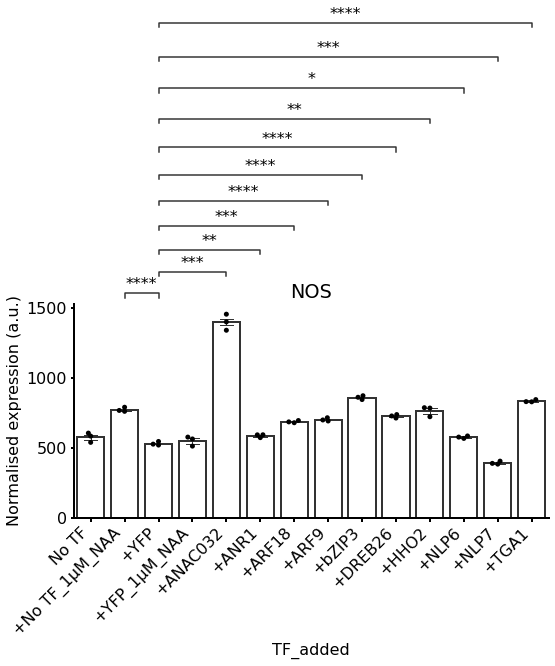

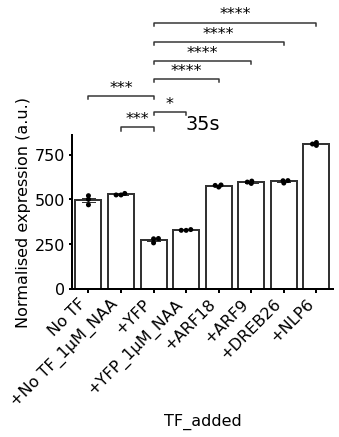

In [ ]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
# #plots for promoters with more than 2 Tf categories
# #prom == 'minimal_STAP4'
# #set matplotlib default parameters
# rcParams['xtick.major.width'] = 2
# rcParams['ytick.major.width'] = 2
# rcParams['axes.linewidth'] = 2
# #rcParams['lines.linewidth'] = 2
# #remove top and right lines
# rcParams['axes.spines.top'] = False
# rcParams['axes.spines.right'] = False
# #font size
# rcParams['font.size'] = 16
# for prom in prom_names_plate2:
#     if prom == 'STAP4' or prom == 'NOS_calibrator':
#         pass
#     else:
#         df1 = luminescence_raw_df_plate2[luminescence_raw_df_plate2.Promoter == prom].sort_values("TF_added", ascending=False)
#         df2 = luminescence_raw_df_plate2[luminescence_raw_df_plate2.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
#         #change name of TF added in df2 to minimal_stap4        
#         df2['TF_added'] = 'pSTAP4 no TF'
#         df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
#         TFs_orig =  df.TF_added.unique()
#         TF_order = ['No TF','+No TF_1μM_NAA','+YFP','+YFP_1μM_NAA','+ANAC032','+ANR1','+ARF18','+ARF18_1μM_NAA','+ARF9','+ARF9_1μM_NAA','+ARF18+ARF9','+ARF18+ARF9_1μM_NAA','+bZIP3','+DREB26','+HHO2','+NLP6','+NLP7','+TGA1']
#         #sort based on custom order
#         TFs = []
#         for i in range(len(TF_order)):
#             if TF_order[i] in TFs_orig:
#                 TFs+=[TF_order[i]]
#         #print(df)
#         #get length of number of TFs
#         length_tf = len(TFs)
#         #create order and box pairs based on the length of TFs
#         order = []
#         box_pairs = []   
#         for x in range (0, (length_tf)):
#             order.append(TFs[x])
#             if TFs[x] == "+YFP":
#                 pass
#             else:
#                 box_pairs.append(('+YFP',TFs[x]))
#         #add every combination of box pairs of length 2
#         #box_pairs=list(combinations(order, 2))
#         box_pairs_all_pvalues = {}
#         for pair in box_pairs:
#             #create series objects
#             TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
#             TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
#         # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
#         # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
#         #equal variance = false so do Welch's T-test
#             results = stats.ttest_ind(TF1, TF2, equal_var=False)
#             #append pvalue to dict
#             box_pairs_all_pvalues[pair] = results.pvalue
#         # box_pairs_significant.append(pair)
#         # p_values.append(results.pvalue)
#         print(f'all pvalues={box_pairs_all_pvalues}')

#         # #filter dict by significance and put in a new dictionary
#         box_pairs_significant = {}
#         for k,v in box_pairs_all_pvalues.items():
#             if v <0.05:
#                 box_pairs_significant[k] = v
                

        
#         # if len(TFs) is 3:
#         #     order = [TFs[0],TFs[1],TFs[2]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
#         # elif len(TFs) is 4:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
#         # elif len(TFs) is 5:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
#         # elif len(TFs) is 6:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
#         # elif len(TFs) is 7:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
#         # elif len(TFs) is 8:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


#         if len(TFs) < 3:
#             plt.figure()
#             order = [TFs[0],TFs[1]]
#             fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order)


#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
            
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # label box pairs        
#             box_pairs = [(TFs[0],TFs[1])]
#             # make empty list of p_values
#             p_values = []
#             # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             #     print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)

#             # add stats annotation to the plot
#             add_stat_annotation(
#                 fig,
#                 data=df,
#                 x='TF_added',
#                 y='corrected_luminescence',
#                 order=order,
#                 box_pairs=box_pairs,
#                 text_format="star",
#                 loc="outside",
#                 verbose=2,
#                 #perform_stat_test=False,
#                 #pvalues=p_values,
#                 test='Mann-Whitney',
#             )
#         else:
#             print(prom)
#             print(TFs)
#             plt.figure(figsize=((length_tf-(length_tf//2)+1),6))
#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
#             fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, facecolor=(1,1,1,1), errcolor=".2", edgecolor=".2", ci=68, errwidth=1,capsize=0.4)
#             sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, order=order,color='black')
            
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # # label box pairs        
#             # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
#             # # make empty list of p_values
#             # p_values = []
#             # # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             # #    print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)

#             # add stats annotation to the plot
#             #if no significant values, don't add stats annotation
#             if len(box_pairs_significant.values()) < 1:
#                 pass
#             else:
#                 add_stat_annotation(
#                     fig,
#                     data=df,
#                     x='TF_added',
#                     y='corrected_luminescence',
#                     order=order,
#                     box_pairs=list(box_pairs_significant.keys()),
#                     text_format="star",
#                     loc="outside",
#                     verbose=2,
#                     perform_stat_test=False,
#                     pvalues=list(box_pairs_significant.values()),
#                     #test_short_name="Dunn",
#                 )

#             # change axes labels
#             plt.ylabel('Normalised expression (a.u.)')
#             #add title
#             plt.title(prom)
#             #make xticks diagonal
#             plt.xticks(rotation=45, ha='right')
#             #plt.xlabel(x_label)
#             # tight layout
#             plt.tight_layout()
#             # save figure
#             plt.savefig(
#                 f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate2.pdf',
#                 format="pdf",
#                 bbox_inches="tight",
#             )
            


#             #write to file static image and interactive one
#         # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#         #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#         #  fig.show()

In [ ]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
# #plots for promoters 2 Tf categories

# for prom in prom_names_plate1:
#     if prom == 'NOS' or prom == 'STAP4':
#         pass
#     else:
#         df = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
#         TFs =  df.TF_added.unique()
#         print(prom)
#         print(TFs)
#         if len(TFs) is not 2:
#             pass
#         else:
#             plt.figure()
#             order = [TFs[0],TFs[1]]
#             fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order)


#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
            
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # label box pairs        
#             box_pairs = [(TFs[0],TFs[1])]
#             # make empty list of p_values
#             p_values = []
#             # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             #     print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)

#             # add stats annotation to the plot
#             add_stat_annotation(
#                 fig,
#                 data=df,
#                 x='TF_added',
#                 y='corrected_luminescence',
#                 order=order,
#                 box_pairs=box_pairs,
#                 text_format="star",
#                 loc="outside",
#                 verbose=2,
#                 #perform_stat_test=False,
#                 #pvalues=p_values,
#                 test='Mann-Whitney',
#             )
#             # change axes labels
#             plt.ylabel('Mean luminescence (a.u.)')
#             #plt.xlabel(x_label)
#             # tight layout
#             plt.tight_layout()
#             # save figure
            
#             plt.savefig(
#                 f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
#                 format="pdf",
#                 bbox_inches="tight",
#             )           


#         #write to file static image and interactive one
#        # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#       #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#       #  fig.show()

In [ ]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
# #plots for promoters 2 Tf categories

# for prom in prom_names_plate2:
#     if prom == 'NOS' or prom == 'STAP4':
#         pass
#     else:
#         df = luminescence_raw_df_plate2[luminescence_raw_df_plate2.Promoter == prom].sort_values("TF_added", ascending=False)
#         TFs =  df.TF_added.unique()
#         print(prom)
#         print(TFs)
#         if len(TFs) is not 2:
#             pass
#         else:
#             plt.figure()
#             order = [TFs[0],TFs[1]]
#             fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order)


#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
            
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # label box pairs        
#             box_pairs = [(TFs[0],TFs[1])]
#             # make empty list of p_values
#             p_values = []
#             # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             #     print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)

#             # add stats annotation to the plot
#             add_stat_annotation(
#                 fig,
#                 data=df,
#                 x='TF_added',
#                 y='corrected_luminescence',
#                 order=order,
#                 box_pairs=box_pairs,
#                 text_format="star",
#                 loc="outside",
#                 verbose=2,
#                 #perform_stat_test=False,
#                 #pvalues=p_values,
#                 test='Mann-Whitney',
#             )
#             # change axes labels
#             plt.ylabel('Mean luminescence (a.u.)')
#             #plt.xlabel(x_label)
#             # tight layout
#             plt.tight_layout()
#             # save figure
            
#             plt.savefig(
#                 f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate2.pdf',
#                 format="pdf",
#                 bbox_inches="tight",
#             )           


#         #write to file static image and interactive one
#        # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#       #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#       #  fig.show()

In [ ]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
# #plots for promoters with more than 2 Tf categories
# #prom == 'minimal_STAP4'
# for prom in prom_names_plate1:
#     if prom == 'NOS' or prom == 'STAP4':
#         pass
#     else:
#         df1 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
#         df2 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
#         #change name of TF added in df2 to minimal_stap4        
#         df2['TF_added'] = 'pSTAP4 no TF'
#         df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
#         TFs =  df.TF_added.unique()
#         #print(df)
#         #get length of number of TFs
#         length_tf = len(TFs)
#         #create order and box pairs based on the length of TFs
#         order = []
#         box_pairs = []   
#         for x in range (0, (length_tf)):
#             order.append(TFs[x])
#             if TFs[x] == "No TF":
#                 pass
#             else:
#                 box_pairs.append(('No TF',TFs[x]))
#         #add every combination of box pairs of length 2
#         #box_pairs=list(combinations(order, 2))
#         box_pairs_all_pvalues = {}
#         for pair in box_pairs:
#             #create series objects
#             TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
#             TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
#         # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
#         # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
#         #equal variance = false so do Welch's T-test
#             results = stats.ttest_ind(TF1, TF2, equal_var=False)
#             #append pvalue to dict
#             box_pairs_all_pvalues[pair] = results.pvalue
#         # box_pairs_significant.append(pair)
#         # p_values.append(results.pvalue)
#         print(f'all pvalues={box_pairs_all_pvalues}')

#         # #filter dict by significance and put in a new dictionary
#         box_pairs_significant = {}
#         for k,v in box_pairs_all_pvalues.items():
#             if v <0.05:
#                 box_pairs_significant[k] = v
                

        
#         # if len(TFs) is 3:
#         #     order = [TFs[0],TFs[1],TFs[2]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
#         # elif len(TFs) is 4:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
#         # elif len(TFs) is 5:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
#         # elif len(TFs) is 6:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
#         # elif len(TFs) is 7:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
#         # elif len(TFs) is 8:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


#         if len(TFs) < 3:
#             pass
#         else:
#             print(prom)
#             print(TFs)
#             plt.figure(figsize=((length_tf+8),5))
#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
#             fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, order=order, hue='condition')
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # # label box pairs        
#             # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
#             # # make empty list of p_values
#             # p_values = []
#             # # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             # #    print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)
#             #print("valuesSAM = " + str(box_pairs_significant.values()))
#             # add stats annotation to the plot
#             #if no significant values, don't add stats annotation
#             if len(box_pairs_significant.values()) < 1:
#                 pass
#             else:
#                 add_stat_annotation(
#                     fig,
#                     data=df,
#                     x='TF_added',
#                     y='corrected_luminescence',
#                     order=order,
#                     box_pairs=list(box_pairs_significant.keys()),
#                     text_format="star",
#                     loc="outside",
#                     verbose=2,
#                     perform_stat_test=False,
#                     pvalues=list(box_pairs_significant.values()),
#                     #test_short_name="Dunn",
#                 )
#             # change axes labels
#             plt.ylabel('Luminescence (a.u.)')
#             #add title
#             plt.title(prom)
#             #plt.xlabel(x_label)
#             # tight layout
#             plt.tight_layout()
#             # save figure
#             plt.savefig(
#                 f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
#                 format="pdf",
#                 bbox_inches="tight",
#             )
            


#             #write to file static image and interactive one
#         # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#         #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#         #  fig.show()

### test normality

In [ ]:
#returns test statistic, p-value
for name1 in prom_names_plate1:
    for name in names_plate1:
        print(name1,'{}: {}'.format(name, stats.shapiro(luminescence_raw_df_plate1['nluc/fluc'][luminescence_raw_df_plate1.TF_added == name])))


NOS No TF: ShapiroResult(statistic=0.7083108425140381, pvalue=0.00755384610965848)
NOS +YFP: ShapiroResult(statistic=0.865602970123291, pvalue=0.00044452777365222573)
NOS +NLP7: ShapiroResult(statistic=0.8515490293502808, pvalue=0.0023359968326985836)
NOS +HHO2: ShapiroResult(statistic=0.6891829371452332, pvalue=0.004745053593069315)
NOS +bZIP3: ShapiroResult(statistic=0.6970699429512024, pvalue=0.0057565681636333466)
NOS +NLP7+bZIP3: ShapiroResult(statistic=0.8956851959228516, pvalue=0.37189507484436035)
NOS +TGA1: ShapiroResult(statistic=0.7194503545761108, pvalue=0.009845705702900887)
NOS +NLP7+TGA1: ShapiroResult(statistic=0.9247104525566101, pvalue=0.46914464235305786)
minimal_STAP4 No TF: ShapiroResult(statistic=0.7083108425140381, pvalue=0.00755384610965848)
minimal_STAP4 +YFP: ShapiroResult(statistic=0.865602970123291, pvalue=0.00044452777365222573)
minimal_STAP4 +NLP7: ShapiroResult(statistic=0.8515490293502808, pvalue=0.0023359968326985836)
minimal_STAP4 +HHO2: ShapiroResult(

#### not normal

In [ ]:
#test variance
stats.levene(luminescence_raw_df['nluc/fluc'][luminescence_raw_df.TF_added == names[0]], 
               luminescence_raw_df['nluc/fluc'][luminescence_raw_df.TF_added == names[1]])

LeveneResult(statistic=26.208483506980564, pvalue=2.2446306359947897e-06)

In [ ]:
test = luminescence_raw_df.groupby('Promoter')

In [ ]:
test

# one-way ANOVA: scipy.stats.kruskal

In [ ]:
for name in names:
    print(name)

No TF
+ARF9
+HHO2
+ANR1
+bZIP3
+TGA1
+ARF18+ARF9
+ARF18
+ANAC032
+NLP7
+DREB26
+NLP6


In [ ]:
#luminescence anova
for promoter, value in test:
    if promoter == 'ANAC032':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'DREB26'],
                value['corrected_luminescence'][value.TF_added == 'ARF18'],
                value['corrected_luminescence'][value.TF_added == 'DREB26+ARF18']))
    if promoter == 'ANR1':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'ANR1'],
                value['corrected_luminescence'][value.TF_added == 'NLP7'],
                value['corrected_luminescence'][value.TF_added == 'ARF18'],
                value['corrected_luminescence'][value.TF_added == 'DREB26']))
    if promoter == 'ARF18':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'NLP7'],
                value['corrected_luminescence'][value.TF_added == 'DREB26']))
    if promoter == 'NLP6':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'ANR1'],                
                value['corrected_luminescence'][value.TF_added == 'ARF18'],
                value['corrected_luminescence'][value.TF_added == 'DREB26']))
    if promoter == 'DREB26':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],                
                value['corrected_luminescence'][value.TF_added == 'ARF18'],
               ))
    if promoter == 'NLP7':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'ANR1'],
                value['corrected_luminescence'][value.TF_added == 'NLP7'],                
                value['corrected_luminescence'][value.TF_added == 'DREB26'],
                value['corrected_luminescence'][value.TF_added == 'ANAC032'],))
    
    if promoter == 'NIR1':
            
            print(promoter)     
            print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'NLP6+NLP7'],
                value['corrected_luminescence'][value.TF_added == 'NLP7'],                
                value['corrected_luminescence'][value.TF_added == 'DREB26'],
                value['corrected_luminescence'][value.TF_added == 'NLP6+NLP7+DREB26'],
                value['corrected_luminescence'][value.TF_added == 'NLP6']))        


ANAC032
F_onewayResult(statistic=nan, pvalue=nan)
ANR1
F_onewayResult(statistic=nan, pvalue=nan)
ARF18
F_onewayResult(statistic=nan, pvalue=nan)
DREB26
F_onewayResult(statistic=nan, pvalue=nan)
NIR1
F_onewayResult(statistic=nan, pvalue=nan)
NLP6
F_onewayResult(statistic=nan, pvalue=nan)
NLP7
F_onewayResult(statistic=nan, pvalue=nan)


/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/scipy/stats/stats.py:3612: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


In [ ]:
df = luminescence_raw_df
#First rerun NIR1 it as a GLM
NIR1 = df[df.Promoter == 'NIR1']  
results = ols('corrected_luminescence ~ C(TF_added)', data=NIR1).fit()
results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     corrected_luminescence   R-squared:                       1.000
Model:                                OLS   Adj. R-squared:                  1.000
Method:                     Least Squares   F-statistic:                 1.865e+04
Date:                    Mon, 02 Aug 2021   Prob (F-statistic):           2.91e-59
Time:                            15:43:24   Log-Likelihood:                -32.491
No. Observations:                      45   AIC:                             88.98
Df Residuals:                          33   BIC:                             110.7
Df Model:                              11                                         
Covariance Type:                nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      6.7245      0.336     20.023      0.000       6.041       7.408
C(TF_added)[T.+ANR1]          -0.9453      0.475     -1.990      0.055      -1.912       0.021
C(TF_added)[T.+ARF18]         -5.5688      0.411    -13.539      0.000      -6.406      -4.732
C(TF_added)[T.+ARF18+ARF9]    -5.3439      0.411    -12.993      0.000      -6.181      -4.507
C(TF_added)[T.+ARF9]          -4.6423      0.411    -11.287      0.000      -5.479      -3.806
C(TF_added)[T.+DREB26]        -2.4859      0.475     -5.234      0.000      -3.452      -1.520
C(TF_added)[T.+HHO2]          -3.3290      0.475     -7.009      0.000      -4.295      -2.363
C(TF_added)[T.+NLP6]          51.5304      0.475    108.500      0.000      50.564      52.497
C(TF_added)[T.+NLP7]         148.5001      0.475    312.675      0.000     147.534     149.466
C(TF_added)[T.+TGA1]           2.2719      0.475      4.784      0.000       1.306       3.238
C(TF_added)[T.+bZIP3]          0.7928      0.475      1.669      0.105      -0.173       1.759
C(TF_added)[T.No TF]          -2.3599      0.475     -4.969      0.000      -3.326      -1.394
==============================================================================
Omnibus:                       52.636   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              560.059
Skew:                           2.459   Prob(JB):                    2.43e-122
Kurtosis:                      19.568   Cond. No.                         14.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# #make anova table for NIR1
# aov_table = sm.stats.anova_lm(results, typ=2)
# aov_table

In [ ]:
# #pairwise tukey posthoc test for NIR1

    
# mc = MultiComparison(NIR1['corrected_luminescence'], NIR1['TF_added'])
# mc_results = mc.tukeyhsd()
# print(mc_results)

In [ ]:
rp.summary_cont(NIR1['corrected_luminescence'].groupby(NIR1['TF_added']))

,N,Mean,SD,SE,95% Conf.,Interval
TF_added,,,,,,
+ANAC032,3,6.724485,0.023889,0.013793,6.691376,6.757594
+ANR1,3,5.779182,0.026019,0.015022,5.743122,5.815242
+ARF18,6,1.155667,0.057076,0.023301,1.105638,1.205697
+ARF18+ARF9,6,1.380576,0.151005,0.061647,1.248215,1.512937
+ARF9,6,2.082164,0.081723,0.033363,2.010530,2.153797
+DREB26,3,4.238549,0.044260,0.025553,4.177208,4.299890
+HHO2,3,3.395499,0.054186,0.031284,3.320401,3.470596
+NLP6,3,58.254933,0.322122,0.185977,57.808494,58.701372
+NLP7,3,155.224614,2.281168,1.317033,152.063076,158.386152


In [ ]:
ANR1 = df[df.Promoter == 'ANR1']
rp.summary_cont(ANR1['corrected_luminescence'].groupby(ANR1['TF_added']))


,N,Mean,SD,SE,95% Conf.,Interval
TF_added,,,,,,
+ANAC032,3,15.083662,0.344479,0.198885,14.606239,15.561086
+ANR1,3,9.594051,0.196969,0.113720,9.321065,9.867036
+ARF18,6,3.382318,0.729296,0.297734,2.743062,4.021574
+ARF18+ARF9,6,3.770632,0.431280,0.176069,3.392599,4.148666
+ARF9,6,3.275840,0.127926,0.052225,3.163708,3.387972
+DREB26,3,19.188573,0.481732,0.278128,18.520927,19.856219
+HHO2,3,11.415834,0.268452,0.154991,11.043779,11.787889
+NLP6,3,10.353489,0.269201,0.155423,9.980396,10.726582
+NLP7,3,7.897732,0.168792,0.097452,7.663798,8.131666


In [ ]:
for promoter, value in test:
    print('\033[1m' +promoter + '\033[0m')
    print(kruskal(data=df[df.Promoter == promoter], dv='corrected_luminescence', between='TF_added'))
    print('')

NOS
           Source  ddof1    H  p-unc
Kruskal  TF_added      0  0.0    NaN

STAP4
           Source  ddof1    H  p-unc
Kruskal  TF_added      0  0.0    NaN

35s


ZeroDivisionError: division by zero

In [ ]:
#run Dunn's post-hoc test
#ANR1
sp.posthoc_dunn(df[df.Promoter == 'ANR1'], val_col='corrected_luminescence', group_col='TF_added', p_adjust='bonferroni')

,ANR1,ARF18,DREB26,NLP7,None
ANR1,-1.000000,1.000000,0.071163,1.000000,1.000000
ARF18,1.000000,-1.000000,1.000000,0.454646,1.000000
DREB26,0.071163,1.000000,-1.000000,0.003175,1.000000
NLP7,1.000000,0.454646,0.003175,-1.000000,0.535796
None,1.000000,1.000000,1.000000,0.535796,-1.000000


In [ ]:
#NIR1 post-hoc test
sp.posthoc_dunn(df[df.Promoter == 'NIR1'], val_col='corrected_luminescence', group_col='TF_added', p_adjust='bonferroni')

,DREB26,NLP6,NLP6+NLP7,NLP6+NLP7+DREB26,NLP7,None
DREB26,-1.000000,0.537726,0.021630,0.052771,0.017535,1.000000
NLP6,0.537726,-1.000000,1.000000,1.000000,1.000000,1.000000
NLP6+NLP7,0.021630,1.000000,-1.000000,1.000000,1.000000,0.070083
NLP6+NLP7+DREB26,0.052771,1.000000,1.000000,-1.000000,1.000000,0.206551
NLP7,0.017535,1.000000,1.000000,1.000000,-1.000000,0.094729
None,1.000000,1.000000,0.070083,0.206551,0.094729,-1.000000
